# Week 01 — SOFI for Images: Segment Ranking & MoRF Comparison

## Block 1 — Colab bootstrap (repeat of Part 0)

This cell rebuilds the exact environment I used in the initial assignment so Week-1 runs are reproducible in Google Colab. Colab VMs are ephemeral, so package versions and my `/src` editable install don’t persist across notebooks. This block:

- mounts Drive and auto-locates `PROJ_ROOT`
- pins key libs (NumPy first, then Torch CUDA wheels with CPU fallback) and Captum
- installs my project in editable mode (`-e`, `--no-deps`) so the code under `/src` is reused exactly
- **hard-restarts** the kernel once so ABI/memory are clean (one-time, guarded by a marker file)

After the restart, re-run the cell once more: it just prints versions and exposes two safe Drive writers.  
Tip: set `CXR_FORCE_CLEAN=0` to skip the uninstall step if you’re iterating quickly. Keep the pins unless you want to invalidate the “same as submission” guarantee.


In [1]:
# --- Block 1 (fixed): Colab-only bootstrap with one-time restart -------------
import sys, os, subprocess, platform, time
from pathlib import Path

# Detect if code is running inside Google Colab by checking loaded modules.
# Side effect: enables Colab-specific behavior (Drive mount, pip pins, restart).
IN_COLAB = "google.colab" in sys.modules
print(f"🐍 Python: {sys.version.split()[0]} | Colab: {IN_COLAB}")

def sh(cmd: str):
    # Thin wrapper around subprocess.run for shell commands with simple error handling.
    # Raises SystemExit on non-zero return to halt the notebook early and surface the failing command.
    print(">>", cmd)
    r = subprocess.run(cmd, shell=True)
    if r.returncode != 0:
        raise SystemExit(r.returncode)

# Marker file used to prevent infinite restarts of the Colab runtime.
# Presence of this file indicates the first-run bootstrap has completed.
MARK = Path("/content/_cxr_bootstrap_done")

# Resolve project root depending on environment.
# In Colab: try common Drive locations, else fallback to current working directory.
# Outside Colab: allow override via CXR_PROJ_ROOT env var, else cwd.
if IN_COLAB:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=False)  # Avoid remount churn; user can toggle if needed.
    print("✅ Google Drive mounted")
    CANDIDATES = [
        Path("/content/drive/MyDrive/code/chest-xray-lab"),  # Preferred repo path
        Path("/content/drive/MyDrive/chest_xray_lab"),       # Alternate naming
        Path.cwd(),                                          # Fallback to notebook directory
    ]
else:
    CANDIDATES = [Path(os.environ.get("CXR_PROJ_ROOT", Path.cwd()))]

# Pick the first existing candidate as the canonical project root.
# Note: if multiple exist, ordering matters; consider logging a warning in multi-match situations.
PROJ_ROOT = next((p.resolve() for p in CANDIDATES if p.exists()), Path.cwd().resolve())
os.environ["CXR_PROJ_ROOT"] = str(PROJ_ROOT)  # Export for child processes (e.g., pip, editable install).
print("📁 PROJECT ROOT:", PROJ_ROOT)

# Add src/ to the import path to support 'editable-like' imports without installing.
SRC_DIR = PROJ_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

# First-time bootstrap path (only in Colab and only if MARK doesn't exist yet).
# Performs pinning/uninstall to harmonize binary dependencies and avoid ABI mismatches.
if IN_COLAB and not MARK.exists():
    # Patch 'requires-python' in pyproject for Colab base kernels that lag behind.
    # Caution: mutates repository file; safe for Colab but avoid committing this change upstream.
    pyproject = PROJ_ROOT / "pyproject.toml"
    if pyproject.exists():
        txt = pyproject.read_text()
        if 'requires-python = ">=3.12"' in txt:
            print("⚠️ Patching requires-python to >=3.10 for Colab base kernel…")
            pyproject.write_text(txt.replace('requires-python = ">=3.12"', 'requires-python = ">=3.10"'))

    # Clean slate to prevent silent ABI conflicts (NumPy/Torch/Scipy stack).
    # Set CXR_FORCE_CLEAN=0 to skip aggressive uninstalls when debugging.
    if os.environ.get("CXR_FORCE_CLEAN", "1") == "1":
        sh("pip -q uninstall -y "
           "torch torchvision torchaudio "
           "numpy pandas scipy scikit-learn scikit-image "
           "matplotlib "
           "opencv-python opencv-contrib-python opencv-python-headless "
           "jax jaxlib pillow tabulate kagglehub captum torchcam || true")
        sh("pip -q install --upgrade pip")  # Keep pip recent to reduce resolver quirks.

    # 1) Pin NumPy FIRST to a version compatible with PyTorch 2.2 wheels on Colab.
    # Rationale: prevents resolver from upgrading NumPy to an ABI that mismatches Torch.
    sh("pip install --no-cache-dir numpy==1.26.4")

    # 2) Install Torch 2.2.2 with CUDA wheels where available; fallback logic handles Colab GPU variants.
    # Tries CUDA 12.1 then 11.8. If both fail (e.g., CPU runtime), installs CPU wheels from Torch index.
    for wheels in (
        "torch==2.2.2+cu121 torchvision==0.17.2+cu121 torchaudio==2.2.2+cu121",
        "torch==2.2.2+cu118 torchvision==0.17.2+cu118 torchaudio==2.2.2+cu118",
    ):
        try:
            sh(f"pip install --no-cache-dir -f https://download.pytorch.org/whl/torch_stable.html {wheels}")
            break
        except SystemExit:
            pass
    else:
        print("⚠️ GPU wheels failed; installing CPU wheels")
        sh("pip install --no-cache-dir --index-url https://download.pytorch.org/whl/cpu "
           "torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2")

    # 3) Install the rest of the scientific stack with strict pins where stability is critical.
    # Matplotlib pinned with fallback spec to accommodate transient wheel availability on Colab images.
    try:
        sh("pip install --no-cache-dir matplotlib==3.10.7")
    except SystemExit:
        sh("pip install --no-cache-dir 'matplotlib>=3.10,<3.11'")
    sh("pip install --no-cache-dir pandas==2.3.3 scipy==1.16.2 scikit-learn==1.7.2 scikit-image==0.25.2 tabulate==0.9.0 kagglehub==0.3.13")
    try:
        sh("pip install --no-cache-dir opencv-python==4.9.0.80")
    except SystemExit:
        # Headless fallback avoids GUI backends not present on Colab; functionality is similar for CV workloads.
        sh("pip install --no-cache-dir opencv-python-headless==4.9.0.80")

    # 4) Model interpretability tooling (optional extras).
    # Captum is aligned with Torch 2.2; TorchCAM kept optional to encourage custom Grad-CAM if desired.
    sh("pip install --no-cache-dir captum==0.7.0")
    # Optional: drop torchcam and implement Grad-CAM yourself
    # sh("pip install --no-cache-dir torchcam==0.4.0")

    # 5) Editable install of the repo WITHOUT dependency resolution.
    # --no-deps ensures previously pinned wheels aren't re-resolved by project metadata.
    sh(f"pip install --no-cache-dir -e {PROJ_ROOT} --no-deps")

    # 6) Create marker and force a hard restart to ensure the runtime imports the freshly pinned ABIs.
    # Using SIGKILL avoids partial state; the guard MARK prevents infinite restart loops.
    MARK.touch()
    import os as _os
    _os.kill(_os.getpid(), 9)

# Second run (post-restart): import and print versions to verify environment health.
# Skips all uninstall/install work; functions as a quick sanity check plus utility defs.
if IN_COLAB:
    import numpy as np, torch, cv2, pandas, scipy, sklearn, skimage, matplotlib
    print("python:", sys.version.split()[0], "|", platform.platform())
    print("numpy:", np.__version__)
    print("torch :", torch.__version__, "| CUDA?", torch.cuda.is_available())  # Note: torch.cuda.is_available() reflects driver/runtime availability.
    print("cv2   :", cv2.__version__)
    print("pandas:", pandas.__version__, "| scipy:", scipy.__version__)
    print("sklearn:", sklearn.__version__, "| skimage:", skimage.__version__)
    print("matplotlib:", matplotlib.__version__)

    # Lightweight, robust file writers for Google Drive to mitigate sync lag / buffering issues.
    # safe_write_bytes ensures data durability by fsync + size check with retries.
    import io
    def safe_write_bytes(path: Path, data: bytes, retries: int = 3, sleep_s: float = 0.5):
        path.parent.mkdir(parents=True, exist_ok=True)
        with open(path, "wb") as f:
            f.write(data); f.flush(); os.fsync(f.fileno())
        for _ in range(retries):
            if path.exists() and path.stat().st_size == len(data):
                return True
            time.sleep(sleep_s)
        raise IOError(f"Drive sync failed for {path}")
    def safe_write_text(path: Path, text: str): return safe_write_bytes(path, text.encode("utf-8"))
    globals().update(dict(safe_write_bytes=safe_write_bytes, safe_write_text=safe_write_text))
    # Note: safe_write_* return True on success; callers may want to assert the return or handle exceptions.


🐍 Python: 3.12.12 | Colab: True
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted
📁 PROJECT ROOT: /content/drive/MyDrive/code/chest-xray-lab
python: 3.12.12 | Linux-6.6.105+-x86_64-with-glibc2.35
numpy: 1.26.4
torch : 2.2.2+cu121 | CUDA? True
cv2   : 4.9.0
pandas: 2.3.3 | scipy: 1.16.2
sklearn: 1.7.2 | skimage: 0.25.2
matplotlib: 3.10.7


## Block 2 — Load Part-0 config & recreate the exact state

This picks up where the submitted assignment left off. I load the minimal manifest created in **Part-0** (paths to cached PNGs, the trained checkpoint, seed, and the preprocessing hash + train mean/std). The goal is to **recreate the same dataset view and model state** without re-running the big training notebook.

What this cell does:
- resolves `PROJ_ROOT` and adds `src/` so all project imports work anywhere
- reads `part0_min.json` (or the path in `CXR_PART0_CFG`) for: `ckpt_path`, `seed`, `preproc_hash`, `train_mean01/std01`, and the CSVs with cached pairs
- picks a device (CUDA → MPS → CPU) and re-applies the same seed
- loads cached train/val/test pairs from the CSVs (exact same splits as the submission)
- rebuilds the **same** EfficientNet-B0 (1-channel) and loads weights from the checkpoint, then switches to `eval()`  

Result: a clean, reproducible bootstrap that matches Part-0’s environment and data split, ready for Week-1 experiments.


In [2]:
import os, sys, json
from pathlib import Path

# 0) Resolve project + add src/ so imports work from any notebook folder
# Prefer CXR_PROJ_ROOT if set; otherwise fall back to current working directory.
# Prepending src/ enables package-style imports without reinstalling.
PROJ_ROOT = Path(os.environ.get("CXR_PROJ_ROOT", Path.cwd())).resolve()
SRC_DIR   = PROJ_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

# 1) Load minimal config produced in Part-0
# Reads a self-contained JSON manifest (paths + seed + preproc hash + stats).
# Allows running Week-1 notebook independently of Part-0 code.
cfg_path = Path(os.environ.get("CXR_PART0_CFG",
                               PROJ_ROOT / "data/processed/manifests/part0_min.json")).resolve()
cfg = json.loads(cfg_path.read_text())

# Materialize key fields; keep absolute paths to avoid cwd-dependence.
CKPT_PATH = Path(cfg["ckpt_path"]).resolve()
SEED      = int(cfg["seed"])
PHASH     = cfg["preproc_hash"]
MEAN01    = float(cfg["train_mean01"])
STD01     = float(cfg["train_std01"])
TRAIN_CSV = Path(cfg["csv"]["train"]).resolve()
VAL_CSV   = Path(cfg["csv"]["val"]).resolve()
TEST_CSV  = Path(cfg["csv"]["test"]).resolve()

# 2) Device + seed (local, no other envs needed)
# Simple device selection: CUDA > MPS > CPU. Use the same seed for reproducibility.
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available()
                      else "mps" if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
                      else "cpu")
from chest_xray_lab.utils.repro import set_global_seed
set_global_seed(SEED)

print(f"Device: {DEVICE} | Seed: {SEED} | Preproc hash: {PHASH}")

# 3) Read cached-pairs CSVs ([(png_path,label), ...])
# Minimal CSV reader: assumes header "png_path,label" and no commas in paths.
# Produces a list of (cached_png_path, int_label) for loaders/eval.
def read_pairs(csv_path: Path):
    pairs = []
    with open(csv_path) as f:
        header = f.readline()
        for line in f:
            p, y = line.rstrip("\n").split(",")
            pairs.append((p, int(y)))
    return pairs

cached_train = read_pairs(TRAIN_CSV)
cached_val   = read_pairs(VAL_CSV)
cached_test  = read_pairs(TEST_CSV)
print("Pairs:", len(cached_train), "train |", len(cached_val), "val |", len(cached_test), "test")
print(f"Baseline mean [0,1]: {MEAN01:.6f} (std {STD01:.6f})")

# 4) Build + load the model (exact arch), set eval
# Must match Part-0 training config: EfficientNet-B0, 1 input channel.
# map_location=DEVICE ensures checkpoints load correctly on CPU/GPU/MPS.
from chest_xray_lab.models.build import build_model
from chest_xray_lab.models.load  import load_checkpoint

model = build_model("efficientnet_b0", pretrained=False, in_chans=1).to(DEVICE)
model = load_checkpoint(model, CKPT_PATH, map_location=DEVICE)
print("Model loaded from:", CKPT_PATH)

Device: cuda | Seed: 42 | Preproc hash: 3a0b791144
Pairs: 4719 train | 530 val | 607 test
Baseline mean [0,1]: 0.575170 (std 0.172597)
Model loaded from: /content/drive/MyDrive/code/chest-xray-lab/checkpoints/best_model.pt


## Block 3 — Minimal helpers: logits → probability, I/O, and positive sampler

This block defines the tiny utilities I use everywhere in Week-1:

- `_to_prob(model, x)`: converts my model’s **single logit** to a positive-class probability via `sigmoid` and returns shape `[B]`. Assumes inputs are already `float32` tensors on the correct device.
- `prob_pos(...)` / `prob_pos_batch(...)`: single/batched wrappers that also enforce `[0,1]` sanity.
- `load_gray01(path)`: reads a grayscale PNG/JPEG with OpenCV and normalizes to `[0,1]`. Raises if the path is broken.
- `sample_positive_examples(...)`: scores the provided `(png_path, label)` pairs with the current model, keeps items with `p0 ≥ min_p0`, shuffles with a seed, then returns the top-k sorted by confidence.


In [3]:
import random, cv2, numpy as np, torch
from pathlib import Path


@torch.no_grad()
def _to_prob(model, x: torch.Tensor) -> torch.Tensor:
    """
    Model returns a *logit*. Turn it into p(y=1) in [0,1].
    """
    model.eval()
    logit = model(x)                      # shape [B,1] or [B]
    prob = torch.sigmoid(logit).float()
    return prob.view(prob.shape[0], -1)[:, 0]



@torch.no_grad()
def prob_pos(model, gray01: np.ndarray, device) -> float:
    # gray01 expected in [0,1], H×W; wrap to [1,1,H,W] and move to device.
    x = torch.from_numpy(gray01).float().unsqueeze(0).unsqueeze(0).to(device)
    p = _to_prob(model, x)[0].item()
    assert 0.0 <= p <= 1.0, f"p0 out of bounds: {p}"  # Sanity check during bring-up.
    return p

@torch.no_grad()
def prob_pos_batch(model, imgs: torch.Tensor) -> np.ndarray:
    # imgs: [B,1,H,W] float32 already on device; returns np array [B].
    p = _to_prob(model, imgs)
    return p.detach().cpu().numpy()



def load_gray01(path: str) -> np.ndarray:
    # Read grayscale with OpenCV; normalize to [0,1] float32.
    g = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if g is None: raise FileNotFoundError(path)
    return (g.astype(np.float32) / 255.0)

def sample_positive_examples(model, pairs, device, k=10, min_p0=0.5, seed=42):
    # Scan (png_path,label) pairs, score with current model, keep those with p0 ≥ threshold.
    cand = []
    for p, y in pairs:
        g = load_gray01(p)                    # Expect cached PNGs; fast I/O.
        p0 = prob_pos(model, g, device)
        if p0 >= min_p0:
            cand.append((p, int(y), float(p0)))
    if not cand:
        raise RuntimeError(f"No positives with p0 >= {min_p0}.")
    rng = random.Random(seed); rng.shuffle(cand)  # Reproducible shuffle; independent of np/torch seeds.
    take = cand[:min(k, len(cand))]
    take.sort(key=lambda t: t[2], reverse=True)  # Return top-k by p0 (desc).
    return take


## Fast I/O prelude (Colab-only): mirror cached PNGs to `/content` and remap test paths

Colab file I/O from Drive can be painfully slow. This block mirrors the **already cached** preprocessed PNGs from Drive to local SSD (`/content`) and rewrites the test image paths to point at the local mirror. It tries `rsync` first (fast, incremental); if that’s not available, it falls back to a shallow Python copy.

- Inputs: the preproc hash `PHASH` from Part-0, and the cached `cached_test` pairs.
- Output: `cached_test_fast` with paths remapped to the local cache (non-Colab: it’s a no-op).
- Safety: the mirror only contains preprocessed PNGs, not raw data; it deletes/replaces as needed to keep in sync.

**Why:** keeps MoRF/SOFI loops GPU-bound instead of waiting on Drive. On my Colab runtime this step takes ~2 minutes to complete the initial mirror.


In [4]:
# --- Fast I/O prelude (Colab only): mirror cached PNGs to /content and remap paths
import os, sys, shutil
from pathlib import Path
import pandas as pd

if IN_COLAB:
    assert "PHASH" in globals(), "PHASH must be defined (your preproc hash)"
    DRIVE_IMG_ROOT = Path(f"{PROJ_ROOT}/data/processed/chest_xray_split/cache_{PHASH}/images")
    LOCAL_IMG_ROOT = Path(f"/content/chest_xray_cache/cache_{PHASH}/images")

    # 1) ensure destination exists
    LOCAL_IMG_ROOT.mkdir(parents=True, exist_ok=True)

    # 2) try rsync first (fast), fall back to python copy
    try:
        # note: trailing slashes matter for rsync
        src = str(DRIVE_IMG_ROOT) + "/"
        dst = str(LOCAL_IMG_ROOT) + "/"
        exit_code = os.system(f'time rsync -a --delete --info=progress2 "{src}" "{dst}"')
        if exit_code != 0:
            raise RuntimeError("rsync failed")
    except Exception:
        # python fallback: mirror directories (train/val/test) shallowly
        for split in ("train", "val", "test"):
            s = DRIVE_IMG_ROOT / split
            d = LOCAL_IMG_ROOT / split
            if s.exists():
                if d.exists():
                    # clean then copy to keep mirror in sync
                    shutil.rmtree(d)
                shutil.copytree(s, d)

    # 3) build a remapped list pointing at /content for fast reading
    def _remap_pairs(pairs, old_root: Path, new_root: Path):
        old_root = str(old_root).rstrip("/")
        new_root = str(new_root).rstrip("/")
        out = []
        for p, y in pairs:
            out.append((p.replace(old_root, new_root, 1) if p.startswith(old_root) else p, y))
        return out

    cached_test_fast = _remap_pairs(cached_test, DRIVE_IMG_ROOT, LOCAL_IMG_ROOT)
else:
    cached_test_fast = cached_test  # non-Colab: no-op

## Sanity check: use the person-level **TEST** split (not just folders)

We work with a manifest (`test_cached.csv`) that already contains a **person-level** split. That means some images may still live under `images/train/...` on disk, but are logically part of **TEST**.

This block does the following:

1. Load the manifest and filter it to rows where `split == "test"` → this becomes our authoritative TEST list.
2. Normalize paths and compare `cached_test_fast` against that TEST list using a **stable relative key** (last ~4 path parts), so we don’t break if the cache root or Colab mount changes.
3. If **any** cached item is not in the logical TEST list, we raise immediately with a few examples.

**Why:**  
- prevents silent leakage of TRAIN images into the evaluation set for SOFI/SOTA,  
- makes later tables (MoRF AUC per image) reproducible,  
- matches the professor’s “make sure the selected images are correctly classified” comment, because it fixes the *input set* first.

**Output:** prints a ✓ when everything lines up; otherwise raises an `AssertionError` with offending examples.


In [5]:
from pathlib import Path
import pandas as pd

MANIFEST = Path(f"{PROJ_ROOT}/data/processed/manifests/test_cached.csv")

df = pd.read_csv(MANIFEST)

# 1) detect path column
path_candidates = {
    "path", "filepath", "image", "image_path", "img_path", "file"
}
cand_cols = [c for c in df.columns if c.lower() in path_candidates]
path_col = cand_cols[0] if cand_cols else df.columns[0]

# 2) detect label column (common names)
label_candidates = {"label", "y", "target", "class"}
label_col = None
for c in df.columns:
    if c.lower() in label_candidates:
        label_col = c
        break
# label_col can be None – we can still do path-only check

def norm_path(p: str) -> str:
    return str(Path(p)).replace("\\", "/")

def key_from_path(p: str) -> str:
    parts = Path(p).parts
    return "/".join(parts[-4:])   # stable tail for train/ vs test/ mismatch

# 3) build manifest dicts
manifest_paths = df[path_col].astype(str).map(norm_path)
manifest_keys  = manifest_paths.map(key_from_path)

if label_col is not None:
    manifest_labels = df[label_col].astype(int).tolist()
    # key -> label (if duplicates, last one wins — OK for our case)
    manifest_k2y = {
        k: y for k, y in zip(manifest_keys.tolist(), manifest_labels)
    }
else:
    manifest_k2y = None

# 4) build cached sets
cached_keys = []
cached_pairs = []   # (key, y_cached)
for p_cached, y_cached in cached_test_fast:
    k = key_from_path(norm_path(p_cached))
    cached_keys.append(k)
    cached_pairs.append((k, y_cached))

manifest_key_set = set(manifest_keys.tolist())
missing = set(cached_keys) - manifest_key_set
if missing:
    examples = list(missing)[:5]
    raise AssertionError(
        f"{len(missing)} cached_test_fast items are NOT in test_cached.csv. "
        f"Examples: {examples}"
    )

# 5) optional: label consistency check
if manifest_k2y is not None:
    wrong = []
    for k, y_cached in cached_pairs:
        y_manifest = manifest_k2y.get(k, None)
        if y_manifest is None:
            continue
        if int(y_manifest) != int(y_cached):
            wrong.append((k, y_manifest, y_cached))
    if wrong:
        examples = wrong[:5]
        raise AssertionError(
            "Label mismatch between cached_test_fast and test_cached.csv. "
            f"First mismatches: {examples}"
        )

print("✓ cached_test_fast matches test_cached.csv (by path tail" +
      (", labels checked" if manifest_k2y is not None else ", no label column to check") +
      ").")


✓ cached_test_fast matches test_cached.csv (by path tail, labels checked).


### Pick 10 positive **test** images (stratified) + build segments for one debug case

I’m not just taking the top-confidence positives; I stratify by the model’s initial p(pos) into bins (0.50–0.70–0.85–0.95–1.00) and sample roughly evenly. That gives a diverse set of “easy → hard” positives so MoRF curves aren’t biased toward only near-certain cases. The seed makes the selection reproducible.

Below, I:
- score all **test** positives, bin them by p₀, and sample ~equal per bin (then top-up if needed);
- print the chosen 10 with their p₀;
- take the first one as a debug example and compute SLIC superpixels (same params I’ll use everywhere: `n_segments=160`, `compactness=10.0`, `sigma=1.0`, grayscale pipeline);
- define the occlusion baseline as the image mean in [0,1] so it’s consistent across SOFI/SOTA.

`DEV`/`K_SEG` can be flipped for more superpixels later; keep the same values across methods for fair comparisons.


In [6]:
# --- Pick a diverse (stratified) set of 10 TEST positives --------------------
def stratified_correct_positives(
    model,
    pairs,
    device,
    seed=42,
    k_total=10,
    bins=(0.50, 0.70, 0.85, 0.95, 1.01),
    pos_thr=0.5,
):
    import random
    rng = random.Random(seed)
    scored = []

    for p, y in pairs:
        if y != 1:
            continue

        g = load_gray01(p)
        p0 = prob_pos(model, g, device)   # model's prob for pneumonia
        pred = 1 if p0 >= pos_thr else 0  # model's label

        # professor's request: only keep correctly classified
        if pred != y:
            continue

        # only start stratifying from the lowest bin edge
        if p0 >= bins[0]:
            scored.append((p, 1, float(p0)))

    # bin by p0
    buckets = [[] for _ in range(len(bins) - 1)]
    for trip in scored:
        p0 = trip[2]
        for i in range(len(bins) - 1):
            if bins[i] <= p0 < bins[i + 1]:
                buckets[i].append(trip)
                break

    # sample per bin, then top up
    per = max(1, k_total // len(buckets))
    out = []
    for b in buckets:
        rng.shuffle(b)
        out.extend(b[:per])

    if len(out) < k_total:
        leftovers = [t for b in buckets for t in b if t not in out]
        rng.shuffle(leftovers)
        out.extend(leftovers[: (k_total - len(out))])

    # highest confidence first (useful for debugging)
    out.sort(key=lambda t: t[2], reverse=True)
    return out[:k_total]


top_pos = stratified_correct_positives(
    model,
    cached_test_fast,
    DEVICE,
    seed=SEED,
    k_total=10,
    bins=(0.70, 0.85, 0.95, 1.01),
    pos_thr=0.5,
)

print("Selected (stratified) CORRECT positives:")
for p, y, p0 in top_pos:
    print(f"{p} | y={y} | p0={p0:.3f}")


# --- Take the first for debugging (change idx to test another) ---------------
idx = 0
img_path, y_true, _ = top_pos[idx]

# --- Inputs for explainer ----------------------------------------------------
g0 = load_gray01(img_path).astype(np.float32)  # HxW, in [0,1]
assert g0.ndim == 2 and 0.0 <= g0.min() <= g0.max() <= 1.0

from chest_xray_lab.explain.segmentation import compute_superpixels_from_gray, overlay_boundaries

DEV = True
K_SEG   = 160 if DEV else 240     # dev knob: fewer superpixels → faster
COMPACT = 10.0                    # keep consistent across runs
SIGMA   = 1.0                     # small denoise
USE_LAB = False                   # LAB can be slower; keep False unless needed

seg0, rgb_for_vis = compute_superpixels_from_gray(
    g0, n_segments=K_SEG, compactness=COMPACT, sigma=SIGMA, use_lab=USE_LAB
)
seg0 = seg0.astype(np.int32)      # labels 0..K-1

# baseline value in same space as g0 (consistent across methods)
MEAN01 = float(g0.mean())

print("Built g0/seg0 for:", img_path, "| K =", int(seg0.max())+1)


Selected (stratified) CORRECT positives:
/content/chest_xray_cache/cache_3a0b791144/images/test/PNEUMONIA/person112_bacteria_538.jpeg | y=1 | p0=0.999
/content/chest_xray_cache/cache_3a0b791144/images/train/PNEUMONIA/person520_bacteria_2204.jpeg | y=1 | p0=0.999
/content/chest_xray_cache/cache_3a0b791144/images/train/PNEUMONIA/person1439_virus_2453.jpeg | y=1 | p0=0.976
/content/chest_xray_cache/cache_3a0b791144/images/train/PNEUMONIA/person475_bacteria_2025.jpeg | y=1 | p0=0.969
/content/chest_xray_cache/cache_3a0b791144/images/train/PNEUMONIA/person841_virus_1481.jpeg | y=1 | p0=0.937
/content/chest_xray_cache/cache_3a0b791144/images/train/PNEUMONIA/person154_virus_305.jpeg | y=1 | p0=0.932
/content/chest_xray_cache/cache_3a0b791144/images/train/PNEUMONIA/person115_virus_219.jpeg | y=1 | p0=0.898
/content/chest_xray_cache/cache_3a0b791144/images/train/PNEUMONIA/person435_virus_885.jpeg | y=1 | p0=0.792
/content/chest_xray_cache/cache_3a0b791144/images/train/PNEUMONIA/person21_bacteri

## SOFI core: how I build and optimize the MoRF order

This section contains the mechanics behind SOFI on images. The goal is to **find a segment ordering that minimizes the area under the MoRF retained curve** (lower AUC = better). I stick to local, instance-based explanations: we measure how the **model’s p(pos)** changes as we progressively replace segments with a neutral **baseline** (the image mean in [0,1]).

What’s inside:

- **AUC on a fixed grid [0..K] → [0..1].**  
  I integrate the retained probability curve \(y_t = p_t / p_0\) with a uniform step. This is the objective SOFI tries to minimize.

- **Segment indexing (torch-friendly).**  
  I precompute per-segment flat indices so I can zero-copy “paint” multiple candidate occlusions in batches on the GPU. This makes everything practical at 100–240 superpixels.

- **MoRF curve (batched, cumulative).**  
  Given an order, I build a **cumulative batch** of images (each step adds one more occluded segment), run a single forward over that batch, and collect the normalized retained curve. Optional knobs: early stop and (off by default) a monotone envelope for plotting.

- **SEED order (greedy baseline).**  
  A fast, reasonable starting order: at each step, try occluding each remaining segment **in batch**, pick the one with the largest probability drop, commit it, and repeat.

- **RAND baseline.**  
  Shuffle orders several times, compute AUCs, and report μ±σ. This is the “uninformed” reference line.

- **SOFI via Hill Climbing (HC).**  
  Start from an initial order and **swap two positions** to form a candidate. If the AUC improves by more than a tiny tolerance, accept; otherwise, count toward **patience**. Stop when patience is exceeded or max iterations is hit.  
  I use a **mixed swap proposal**: half adjacent (local refine), half random (escape local minima). I also support **restarts**: run HC from a greedy init and from a few shuffled inits, keep the global best.

Why this design:
- Everything is **probability-based** and **cumulative**, matching the assignment’s “probability change after marginalization” requirement.
- Batching keeps runtime sane; SEED + HC produce strong orders without exhaustive search.
- RAND gives a sanity check so you can tell if an ordering is actually informative.


### Helpers for `blur` masking method

In [7]:
import cv2
import numpy as np

def make_blur_baseline(gray01: np.ndarray, k: int = 31, sigma: float = 5.0) -> np.ndarray:
    g = (gray01 * 255).astype(np.uint8)
    b = cv2.GaussianBlur(g, (k, k), sigmaX=sigma, sigmaY=sigma)
    return (b.astype(np.float32) / 255.0)

def make_baseline(gray01: np.ndarray, mode: str, dataset_mean: float = MEAN01):
    """
    mode ∈ {"dataset-mean", "black", "white", "blur"}
    returns: float   (for scalar baselines)
         or: (H,W)   (for blur)
    """
    if mode == "dataset-mean":
        if dataset_mean is None:
            dataset_mean = float(gray01.mean())
        return float(dataset_mean)
    if mode == "black":
        return 0.0
    if mode == "white":
        return 1.0
    if mode == "blur":
        return make_blur_baseline(gray01)
    raise ValueError(f"unknown baseline mode: {mode}")

BASELINE_MODE = "dataset-mean"   # "black", "white", "blur"
N_SEGMENTS    = 100

In [8]:
import numpy as np, torch, random
from typing import Dict, Tuple, List

# Optional progress bar (falls back to plain iterator if tqdm not installed/available).
try:
    from tqdm.auto import tqdm
    _HAVE_TQDM = True
except Exception:
    _HAVE_TQDM = False

def _pbar(iterable, total=None, desc=None, disable=False, leave=False):  # leave=False
    # Wrap an iterable with tqdm when available; otherwise return the iterable unchanged.
    if _HAVE_TQDM and not disable:
        return tqdm(iterable, total=total, desc=desc, leave=leave,
                    dynamic_ncols=True, miniters=1)
    return iterable

# ---------- AUC ----------
def auc_uniform_01(y: np.ndarray) -> float:
    # AUC over a sequence sampled uniformly on x∈[0,1]; uses trapezoidal rule.
    # Input: y[t] are values at evenly spaced x; handles degenerate short inputs.
    y = np.asarray(y, dtype=np.float32)
    if y.size < 2:  # guard for degenerate curves
        return float(y.mean() if y.size else 0.0)
    dx = 1.0 / (len(y) - 1)
    trap = getattr(np, "trapezoid", np.trapz)  # prefer new API if available
    return float(trap(y, dx=dx))

# ---------- Segment indices (torch) ----------
def _segment_indices_torch(segmap: np.ndarray, device):
    # Convert a segmentation map (ints 0..K-1) into per-segment flat indices on 'device'.
    # Returns: list of 1D index tensors for each segment, and H,W,K metadata.
    H, W = segmap.shape
    K = int(segmap.max()) + 1
    flat = torch.from_numpy(segmap.reshape(-1).astype(np.int64)).to(device)
    idxs = [(flat == k).nonzero(as_tuple=True)[0] for k in range(K)]  # list[1D indices]
    return idxs, H, W, K

# ---------- Batched helpers ----------
@torch.no_grad()
def _img_to_tensor(gray01: np.ndarray, device):
    # gray01 ∈ [0,1], shape H×W → torch tensor [1,1,H,W] on 'device'.
    # channels_last sets a memory format that can help on some backends.
    t = torch.from_numpy(gray01.astype(np.float32, copy=False)).to(device)
    t = t.unsqueeze(0).unsqueeze(0).contiguous(memory_format=torch.channels_last)  # 1x1xHxW
    return t

# ---------- SEED (cumulative-greedy, batched) ----------
@torch.no_grad()
def seed_order_greedy_cumulative(model, gray01, segmap, baseline, device,
                                 batch_sz=128, show_progress=False):
    cur = _img_to_tensor(gray01, device)
    idxs, H, W, K = _segment_indices_torch(segmap, device)
    remaining = list(range(K)); order = []

    # normalize baseline
    if isinstance(baseline, (int, float, np.floating)):
        baseline_scalar = float(baseline)
        baseline_flat = None
    else:
        baseline_flat = torch.from_numpy(
            np.asarray(baseline, dtype=np.float32).reshape(-1)
        ).to(device)
        baseline_scalar = None

    p_curr = prob_pos_batch(model, cur)[0]
    it = _pbar(range(K), total=K, desc="SEED greedy (cum., batched)", disable=not show_progress)
    flat_cur_1 = cur.view(1, -1)

    for _ in it:
        best_sid, best_drop = None, -1.0
        for b0 in range(0, len(remaining), batch_sz):
            cand = remaining[b0:b0+batch_sz]
            B = len(cand)
            batch = cur.repeat(B, 1, 1, 1)
            flat = batch.view(B, -1)
            for bi, sid in enumerate(cand):
                if baseline_scalar is not None:
                    flat[bi, idxs[sid]] = baseline_scalar
                else:
                    flat[bi, idxs[sid]] = baseline_flat[idxs[sid]]
            probs = prob_pos_batch(model, batch)
            drops = np.maximum(0.0, p_curr - probs)
            j = int(np.argmax(drops))
            if drops[j] > best_drop:
                best_drop = float(drops[j]); best_sid = int(cand[j])

        # commit best_sid into cur
        if baseline_scalar is not None:
            flat_cur_1[0, idxs[best_sid]] = baseline_scalar
        else:
            flat_cur_1[0, idxs[best_sid]] = baseline_flat[idxs[best_sid]]

        p_curr = prob_pos_batch(model, cur)[0]
        order.append(best_sid)
        remaining.remove(best_sid)

    return order


# ---------- MoRF (batched cumulative forward) ----------
@torch.no_grad()
def morf_curve(model, gray01, segmap, order, baseline, device,
               early_stop_p=None, show_progress=False, chunk=128,
               enforce_monotone=False, monotone_tol=1e-3):
    cur = _img_to_tensor(gray01, device)
    idxs, H, W, K = _segment_indices_torch(segmap, device)
    p0 = prob_pos_batch(model, cur)[0]
    eps = 1e-8

    # ---- normalize baseline (scalar vs per-pixel) ----
    if isinstance(baseline, (int, float, np.floating)):
        baseline_scalar = float(baseline)
        baseline_flat = None
    else:
        # (H,W) → flat on device
        baseline_flat = torch.from_numpy(
            np.asarray(baseline, dtype=np.float32).reshape(-1)
        ).to(device)
        baseline_scalar = None

    vals = [1.0]
    total = len(order)
    s = 0
    it = _pbar(range(0, total, chunk), total=(total + chunk - 1)//chunk,
               desc="MoRF steps", disable=not show_progress)

    for _ in it:
        upto = min(total, s + chunk)
        B = upto - s
        batch = cur.repeat(B, 1, 1, 1)      # B x 1 x H x W
        flat  = batch.view(B, -1)

        # row 0
        seg_id0 = order[s]
        if baseline_scalar is not None:
            flat[0, idxs[seg_id0]] = baseline_scalar
        else:
            flat[0, idxs[seg_id0]] = baseline_flat[idxs[seg_id0]]

        # rows 1..B-1
        for bi in range(1, B):
            flat[bi] = flat[bi-1]
            seg_id = order[s + bi]
            if baseline_scalar is not None:
                flat[bi, idxs[seg_id]] = baseline_scalar
            else:
                flat[bi, idxs[seg_id]] = baseline_flat[idxs[seg_id]]

        probs = prob_pos_batch(model, batch)
        vals.extend((probs / max(p0, eps)).tolist())
        cur = batch[-1:].contiguous()
        s = upto

        if early_stop_p is not None and probs[-1] <= early_stop_p:
            vals.extend([vals[-1]] * (total - len(vals) + 1))
            break

    y = np.asarray(vals, dtype=np.float32)

    if enforce_monotone:
        y = np.minimum.accumulate(y + monotone_tol)

    return y, auc_uniform_01(y), float(p0)

# ---------- RAND (uses batched MoRF) ----------
def rand_morf_auc(model, gray01, segmap, baseline, device, repeats=8, seed=42, show_progress=False):
    # Random orders as a sanity baseline; report mean±std AUC across repeats.
    rng = random.Random(seed)
    _, _, _, K = _segment_indices_torch(segmap, device)
    aucs = []
    it = _pbar(range(repeats), total=repeats, desc="RAND repeats", disable=not show_progress)
    for _ in it:
        order = list(range(K)); rng.shuffle(order)
        _, auc, _ = morf_curve(model, gray01, segmap, order, baseline, device, show_progress=False)
        aucs.append(auc)
    return float(np.mean(aucs)), float(np.std(aucs))

# ---------- SOFI (HC) – reuse batched MoRF ----------
def hill_climb_sofi(model, gray01, segmap, init_order, baseline,
                    device, max_iters=800, patience=120, seed=42, tol=1e-6, show_progress=False):
    # Simple hill-climbing on ordering: random swap → accept if MoRF AUC improves by > tol.
    rng = random.Random(seed)
    best = list(init_order)
    _, best_auc, _ = morf_curve(model, gray01, segmap, best, baseline, device, show_progress=False)
    no_imp = 0
    stopped_reason = "max_iters"
    it = _pbar(range(max_iters), total=max_iters, desc="SOFI (HC, batched)", disable=not show_progress)
    for _ in it:
        i, j = rng.randrange(len(best)), rng.randrange(len(best))
        if i == j:
            continue
        cand = list(best); cand[i], cand[j] = cand[j], cand[i]
        _, auc_cand, _ = morf_curve(model, gray01, segmap, cand, baseline, device, show_progress=False)
        if auc_cand < best_auc - tol:
            best, best_auc = cand, auc_cand; no_imp = 0
        else:
            no_imp += 1
            if no_imp >= patience:
                stopped_reason = "patience"
                break
        if _HAVE_TQDM and show_progress:
            it.set_postfix(best_auc=f"{best_auc:.4f}", no_imp=no_imp, stop=stopped_reason)
    return best, float(best_auc)

def _swap_proposal(rng, arr_len):
    """50% adjacent swap (local refine), 50% random far swap (escape)."""
    if rng.random() < 0.5:
        i = rng.randrange(arr_len - 1)
        return i, i+1
    i, j = rng.randrange(arr_len), rng.randrange(arr_len)
    return (i, j) if i != j else _swap_proposal(rng, arr_len)

def hill_climb_sofi_ex(model, gray01, segmap, init_order, baseline,
                       device, max_iters, patience, seed=42, tol=1e-6, show_progress=False):
    """HC with mixed swap proposals + meta (stop reason, iters, best improvement)."""
    rng = random.Random(seed)
    best = list(init_order)
    # Note: enforce_monotone=False keeps raw MoRF variability; use True if you want smoother objective.
    _, best_auc, _ = morf_curve(model, gray01, segmap, best, baseline, device,
                                show_progress=False, enforce_monotone=False)
    no_imp = 0
    stopped_reason = "max_iters"
    best_improvement = 0.0
    iters_done = 0

    it = _pbar(range(max_iters), total=max_iters, desc="SOFI (HC, batched)", disable=not show_progress)
    for _ in it:
        iters_done += 1
        i, j = _swap_proposal(rng, len(best))          # mix of local/global swaps
        cand = list(best); cand[i], cand[j] = cand[j], cand[i]
        _, auc_cand, _ = morf_curve(model, gray01, segmap, cand, baseline, device,
                                    show_progress=False, enforce_monotone=False)
        imp = best_auc - auc_cand
        if imp > tol:
            best, best_auc = cand, auc_cand
            best_improvement = max(best_improvement, imp)
            no_imp = 0
        else:
            no_imp += 1
            if no_imp >= patience:
                stopped_reason = "patience"
                break
        if _HAVE_TQDM and show_progress:
            it.set_postfix(best_auc=f"{best_auc:.4f}", no_imp=no_imp, stop=stopped_reason)
    meta = {"stopped_reason": stopped_reason, "iters_done": iters_done, "best_improvement": float(best_improvement)}
    return best, float(best_auc), meta

def sofi_hc_with_restarts(model, gray01, segmap, baseline, device,
                          restarts=1, patience_scale=2.5, max_iters_per=None,
                          tol=1e-6, seed=42, show_progress=False):
    """Multiple HC restarts; patience and iters scale with K; keep best result across initializations."""
    _, _, _, K = _segment_indices_torch(segmap, device)
    patience = max(60, int(patience_scale * K))            # e.g., ~2.5*K
    max_iters = int(5 * K) if max_iters_per is None else int(max_iters_per)  # ~5*K per restart

    # Initialization pool: greedy SEED (if available) + shuffled orders.
    inits = []
    try:
        inits.append(seed_order_greedy_cumulative(model, gray01, segmap, baseline, device, show_progress=False))
    except Exception:
        pass
    rng = random.Random(seed)
    while len(inits) < restarts:
        o = list(range(K)); rng.shuffle(o); inits.append(o)

    # Run HC from each init; track global best by MoRF AUC.
    best_global, best_auc, best_meta = None, float("inf"), {"stopped_reason":"n/a","iters_done":0,"best_improvement":0.0}
    for r, init in enumerate(inits):
        b, a, m = hill_climb_sofi_ex(model, gray01, segmap, init, baseline, device,
                                     max_iters=max_iters, patience=patience,
                                     seed=seed + r, tol=tol, show_progress=show_progress and (r==0))
        if a < best_auc - tol:
            best_global, best_auc, best_meta = b, a, m
    return best_global, best_auc, best_meta


## SOFI (RL variant): stochastic swaps as an ablation against HC

Here I add a lightweight **RL optimizer** that competes with the hill-climbing (HC) search. The idea is simple: we keep a **soft preference (“prior”) per segment** for appearing earlier in the MoRF order, and we **sample swaps** between two positions using a softmax policy. After each swap, we **reward** the policy if the **RAW MoRF AUC decreases** (improvement).

How it works:

- **State / order.** The current permutation of segments.
- **Action.** Pick a pair of positions \((i<j)\) and swap them. Pair selection is **probabilistic**: pairs with higher “utility” (based on current priors of the items at those positions) get higher probability. A temperature `tau` controls exploration.
- **Reward.** \( r = \text{AUC}_{\text{prev}} - \text{AUC}_{\text{new}} \). Positive means we improved (lower AUC).
- **Update.** REINFORCE-style: we adjust the **priors** of the two swapped items using an **advantage** (reward minus an exponential **baseline** to reduce variance). Intuition: if swapping an item forward helped, its prior nudges up; if not, it nudges down.
- **Budget.** Same order of work as HC (≈ `5*K` iterations), so results are comparable.


In [9]:
# ---------- SOFI (RL) – swap-policy with REINFORCE baseline ----------
import math, numpy as np, random

def _init_priors_from_seed_order(seed_order):
    # Higher prior → earlier in order; simple linear ramp (can be replaced by single-step drops if you precompute them)
    K = len(seed_order)
    priors = np.zeros(K, dtype=np.float64)
    # order indexes segments; earlier gets larger prior
    for rank, sid in enumerate(seed_order):
        priors[sid] = float(K - rank)
    return priors

def _probabilistic_swap(priors, tau, rng):
    """
    Sample a pair (i<j) to swap in the CURRENT permutation (x),
    using priors(x[i]) and priors(x[j]) as utilities.
    """
    n = len(priors)  # priors are indexed by SID; we'll map via current permutation
    # We'll choose indices i<j in positional space using priors on the *items* at those positions.
    # To make this efficient, we prebuild all (i,j) pairs' utilities lazily in the caller
    raise NotImplementedError  # (implemented in the main function below)


def sofi_rl_optimize(model, gray01, segmap, baseline, device, *,
                     tau=0.1, max_iters=None, lr=0.01, baseline_decay=0.9,
                     seed=42, init_order=None, show_progress=False):
    """
    Minimize RAW retained MoRF AUC with a stochastic swap policy (REINFORCE).
    - Policy: softmax over pairwise utilities Δ = prior(item_j) - prior(item_i) for i<j in the *current* permutation.
    - Action: swap positions (i,j).
    - Reward: r = AUC_prev - AUC_new (improvement; positive is good).
    - Update: priors[item_j] += lr * advantage; priors[item_i] -= lr * advantage.
    Notes:
      * We keep scoring purely RAW (enforce_monotone=False) to match assignment.
      * Same budget as HL by default: max_iters ≈ 5 * K.
    Returns: best_order, best_auc_raw, meta
    """
    rng = random.Random(seed)
    idxs, H, W, K = _segment_indices_torch(segmap, device)
    if max_iters is None:
        max_iters = int(5 * K)

    # init permutation: greedy SEED (good prior) or provided
    if init_order is None:
        try:
            init_order = seed_order_greedy_cumulative(model, gray01, segmap, baseline, device, show_progress=False)
        except Exception:
            init_order = list(range(K)); rng.shuffle(init_order)

    # initialize priors from the init permutation (higher → earlier)
    priors = _init_priors_from_seed_order(init_order)

    # evaluate initial
    cur_perm = list(init_order)
    _, cur_auc, _ = morf_curve(model, gray01, segmap, cur_perm, baseline, device,
                               show_progress=False, enforce_monotone=False)
    best_perm, best_auc = list(cur_perm), float(cur_auc)

    # moving baseline for variance reduction
    reward_baseline = 0.0

    # tqdm-lite
    it = _pbar(range(max_iters), total=max_iters, desc="SOFI (RL)", disable=not show_progress)
    for _ in it:
        n = len(cur_perm)

        # Build softmax over all (i<j) pairs in positional space using priors on items at those positions
        i_idx, j_idx = np.triu_indices(n, k=1)
        # utilities = max(0, prior[item_j] - prior[item_i]) like the prof's code
        utilities = np.maximum(
            0.0,
            np.array([priors[cur_perm[j]] - priors[cur_perm[i]] for i, j in zip(i_idx, j_idx)], dtype=np.float64)
        )
        # softmax with temperature tau
        if tau <= 0:
            # greedy fallback
            chosen = int(np.argmax(utilities))
        else:
            logits = utilities / float(tau)
            # numerical stability
            m = float(np.max(logits)) if logits.size else 0.0
            probs = np.exp(logits - m)
            s = float(np.sum(probs)) if probs.size else 1.0
            probs = probs / s
            # handle all-zero utilities
            if not np.isfinite(probs).all() or probs.sum() <= 0:
                probs = np.ones_like(probs) / len(probs)
            chosen = rng.choices(range(len(probs)), weights=probs, k=1)[0]

        i, j = int(i_idx[chosen]), int(j_idx[chosen])

        # Propose swap
        cand = list(cur_perm); cand[i], cand[j] = cand[j], cand[i]
        _, auc_new, _ = morf_curve(model, gray01, segmap, cand, baseline, device,
                                   show_progress=False, enforce_monotone=False)

        # Reward = improvement in RAW AUC
        reward = float(cur_auc - auc_new)
        reward_baseline = baseline_decay * reward_baseline + (1 - baseline_decay) * reward
        advantage = reward - reward_baseline

        # Policy gradient-style update on priors for the *items* we swapped
        item_i, item_j = cur_perm[i], cur_perm[j]
        priors[item_j] += lr * advantage
        priors[item_i] -= lr * advantage

        # Accept if not worse (you can make this strictly better if you want SA-like behavior)
        if reward >= 0:
            cur_perm, cur_auc = cand, auc_new
            if cur_auc < best_auc:
                best_perm, best_auc = list(cur_perm), float(cur_auc)

        if _HAVE_TQDM and show_progress:
            it.set_postfix(best=f"{best_auc:.4f}", cur=f"{cur_auc:.4f}")

    meta = {"iters_done": int(max_iters), "best_auc": float(best_auc)}
    return best_perm, float(best_auc), meta


## Wiring SOFI (HC vs RL) + on-disk caching of curves

This block wraps everything into a single `evaluate_one_image(...)` that:
- builds superpixels for one image,
- computes **SEED → RAND → HC (SOFI_HL)** and (optionally) **RL (SOFI_RL)**,
- **caches** the resulting MoRF curves + orders to disk so I don’t recompute them later.

Key points:

- **Flag `do_rl`:**  
  - `do_rl=False` → only SEED + HC (the assignment’s “HL if RL is not necessary” case).  
  - `do_rl=True` → also runs the RL ablation (same objective, same MoRF definition).
- **Cache behavior (`cache_dir`)**  
  - If provided (I set it to `…/manifests/week1_sofi_curves/arrays`), the function first tries a **fast path**: load `*.npz` (curves/orders) and `*.json` (meta/AUCs).  
  - If **HL/SEED** are already there, it **skips recompute** and only redoes cheap RAND μ±σ.  
  - If **RL** is requested but missing, it computes **RL only**, appends `y_rl/yb_rl/order_rl` to the same `.npz`, and updates the JSON meta.
- **Sanity checks:**  
  - I verify each MoRF curve has exactly **K+1 points** (including t=0), and the **final retained value** equals the model probability on the **all-baseline image** divided by \(p_0\). This guards against off-by-one or normalization bugs.
- **Outputs:**  
  - Returns a small dict per image with **RAW** AUCs (primary), **bounded** AUCs (secondary), a few **meta counters** (HL/RL iters, stop reason), and **k@0.1** for HL/RL.  
  - On disk, you’ll find files like:  
    - `sofi_K160_c10_s10_lab0__person294_virus_611.jpeg.npz` → arrays (`y_seed`, `y_hl`, optional `y_rl`, plus `segmap` and `order_*`)  
    - Matching `.json` → params + AUC summaries.
- **Repro:** seeded runs; same cumulative-occlusion protocol used across SEED/HL/RL; **RAW AUC** is the assignment-facing metric; **bounded** curves are an optional robustness view.

This lets me flip between **HC-only** and **HC+RL** without paying the full compute twice, and it keeps results reproducible and resumable across notebook sessions.


In [10]:
# ---------- Small helpers (once, above) --------------------------------------
import os, json
from pathlib import Path

def _npz_path(cache_dir: Path, img_path: str, n_segments: int, compactness: float, sigma: float, use_lab: bool):
    # Build a cache filename keyed by superpixel parameters + image basename.
    # NPZ will store curves (y_*), segment orders, and the segmap.
    base = Path(img_path).name
    tag = f"K{n_segments}_c{int(compactness)}_s{int(sigma*10)}_lab{int(bool(use_lab))}"
    return Path(cache_dir) / f"sofi_{tag}__{base}.npz"

def _json_path(npz_path: Path):
    # Sidecar JSON for metadata (AUCs, iters, reasons).
    return npz_path.with_suffix(".json")

def _save_npz(p: Path, **arrays):
    # Compressed array store (idempotent dirs).
    p.parent.mkdir(parents=True, exist_ok=True)
    np.savez_compressed(str(p), **arrays)

def _save_json(p: Path, obj: dict):
    # Pretty JSON writer (idempotent dirs).
    p.parent.mkdir(parents=True, exist_ok=True)
    p.write_text(json.dumps(obj, indent=2))

# ---------- Display helpers: bounded + monotone + summaries ----------
def bounded_monotone_curve(y: np.ndarray, monotone_tol: float = 1e-3) -> np.ndarray:
    """
    Input: retained curve y where y[0]=1 and y[t]=p_t/p0 (can exceed 1).
    Output: y_bounded in [0,1], gently non-increasing (cumulative-min envelope).
    """
    yb = np.asarray(y, dtype=np.float32)
    yb = np.clip(yb, 0.0, 1.0)                    # Cap overshoots above 1 (and below 0).
    yb = np.minimum.accumulate(yb + monotone_tol) # Tolerant monotone clamp (removes tiny jiggles).
    return np.clip(yb, 0.0, 1.0)

def retained_auc_bounded(y_bounded: np.ndarray) -> float:
    # Area under the (bounded) retained curve; lower is better (faster degradation).
    return auc_uniform_01(y_bounded)              # ↓ better

def k_at_tau(y_bounded: np.ndarray, tau: float = 0.1) -> int:
    # Step index where retained prob first drops below τ (e.g., 10%).
    hit = np.flatnonzero(y_bounded <= float(tau))
    return int(hit[0]) if hit.size else (len(y_bounded) - 1)



def evaluate_one_image(
    model,
    img_path,
    device,
    *,
    n_segments=160,
    compactness=10.0,
    sigma=1.0,
    use_lab=False,
    repeats_rand=12,
    seed=42,
    do_rl=True,
    show_progress=False,
    cache_dir: Path = None,
    baseline_mode: str = "dataset-mean",    # <--- NEW,
    hc_patience_scale: float = 2.5,
    hc_max_iters_per: int | None = None,
):
    model.eval()
    g0 = load_gray01(img_path).astype(np.float32)


    if baseline_mode == "dataset-mean" and "MEAN01" not in globals():
        raise RuntimeError("dataset-mean selected but MEAN01 not defined")

    seg0, _ = compute_superpixels_from_gray(
        g0,
        n_segments=n_segments,
        compactness=compactness,
        sigma=sigma,
        use_lab=use_lab,
    )
    seg0 = seg0.astype(np.int32)
    K = int(seg0.max()) + 1

    # ---- choose baseline here -------------------------------------
    baseline = make_baseline(g0, mode=baseline_mode, dataset_mean=MEAN01)
    # ---------------------------------------------------------------

    npz_p = _npz_path(cache_dir, img_path, n_segments, compactness, sigma, use_lab) if cache_dir else None
    json_p = _json_path(npz_p) if npz_p else None

    # ---------- fast path ----------
    if npz_p and npz_p.exists() and json_p.exists():
        z = np.load(npz_p, allow_pickle=False)
        meta = json.loads(json_p.read_text())

        y_seed = z["y_seed"]; y_hl = z["y_hl"]
        yb_seed = bounded_monotone_curve(y_seed); yb_hl = bounded_monotone_curve(y_hl)
        auc_seed_raw = auc_uniform_01(y_seed); auc_hl_raw = auc_uniform_01(y_hl)
        auc_seed_b   = retained_auc_bounded(yb_seed); auc_hl_b = retained_auc_bounded(yb_hl)

        rng = random.Random(seed)
        rand_raw = []
        for _ in range(repeats_rand):
            o = list(range(K)); rng.shuffle(o)
            _, auc_r_raw, _ = morf_curve(model, g0, seg0, o, baseline, device, enforce_monotone=False)
            rand_raw.append(auc_r_raw)

        # --- RL branch (same as yours, just pass baseline) ---
        auc_rl_raw = float('nan'); auc_rl_b = float('nan'); k01_rl = 0; rl_iters = 0
        if do_rl:
            has_rl = ("y_rl" in z.files) and ("yb_rl" in z.files)
            if has_rl:
                y_rl = z["y_rl"]; yb_rl = z["yb_rl"]
                auc_rl_raw = auc_uniform_01(y_rl); auc_rl_b = retained_auc_bounded(yb_rl)
                k01_rl = k_at_tau(yb_rl, tau=0.10)
                rl_iters = int(meta.get("rl_meta", {}).get("iters_done", 0))
            else:
                best_rl_order, auc_rl_raw, meta_rl = sofi_rl_optimize(
                    model, g0, seg0, baseline, device,
                    tau=0.1, max_iters=int(5*K), lr=0.01, baseline_decay=0.9,
                    seed=seed+2,
                    init_order=list(z["order_seed"]) if "order_seed" in z.files else None,
                    show_progress=show_progress
                )
                y_rl, _, _ = morf_curve(model, g0, seg0, best_rl_order, baseline, device, enforce_monotone=False)
                yb_rl = bounded_monotone_curve(y_rl); auc_rl_b = retained_auc_bounded(yb_rl)
                k01_rl = k_at_tau(yb_rl, tau=0.10); rl_iters = int(meta_rl.get("iters_done", 0))

                arrays = {k: z[k] for k in z.files}
                arrays.update({
                    "y_rl": y_rl.astype(np.float32),
                    "yb_rl": yb_rl.astype(np.float32),
                    "order_rl": np.asarray(best_rl_order, np.int32),
                })
                _save_npz(npz_p, **arrays)
                meta["aucs"].update({"SOFI_RL_raw": float(auc_rl_raw), "SOFI_RL_b": float(auc_rl_b)})
                meta["rl_meta"] = { "iters_done": rl_iters }
                _save_json(json_p, meta)

        return {
            "img": img_path,
            "K": int(K),
            "p0": float(prob_pos(model, g0, device)),
            "SOFI_HL_raw": float(auc_hl_raw),
            "SOFI_RL_raw": float(auc_rl_raw),
            "SEED_raw": float(auc_seed_raw),
            "RAND_raw_mean": float(np.mean(rand_raw)),
            "RAND_raw_std": float(np.std(rand_raw, ddof=1) if len(rand_raw)>1 else 0.0),
            "SOFI_HL_b": float(auc_hl_b),
            "SOFI_RL_b": float(auc_rl_b),
            "SEED_b": float(auc_seed_b),
            "RAND_b_mean": float('nan'),
            "RAND_b_std": float('nan'),
            "k_at_0p1_HL": int(k_at_tau(yb_hl, tau=0.10)),
            "k_at_0p1_RL": int(k01_rl),
            "hl_iters": int(meta.get("hl_meta", {}).get("iters_done", 0)),
            "rl_iters": int(rl_iters),
            "stop_hl": str(meta.get("hl_meta", {}).get("stopped_reason", "cache")),
        }

    # ---------- normal path ----------
    seed_order = seed_order_greedy_cumulative(model, g0, seg0, baseline, device, show_progress=show_progress)
    y_seed, auc_seed_raw, p0 = morf_curve(model, g0, seg0, seed_order, baseline, device, enforce_monotone=False)
    yb_seed = bounded_monotone_curve(y_seed); auc_seed_b = retained_auc_bounded(yb_seed)

    rng = random.Random(seed)
    rand_b, rand_raw = [], []
    order_rand_ex = None; y_rand_ex = None; yb_rand_ex = None
    for rep in range(repeats_rand):
        order_r = list(range(K)); rng.shuffle(order_r)
        y_r, auc_r_raw, _ = morf_curve(model, g0, seg0, order_r, baseline, device, enforce_monotone=False)
        rand_raw.append(auc_r_raw)
        if rep == 0:
            order_rand_ex = order_r; y_rand_ex = y_r; yb_rand_ex = bounded_monotone_curve(y_r)
        rand_b.append(retained_auc_bounded(bounded_monotone_curve(y_r)))

    best_hl_order, auc_hl_raw, meta_hl = sofi_hc_with_restarts(
        model, g0, seg0, baseline, device,
        restarts=1,
        tol=1e-6,
        seed=seed+1,
        show_progress=show_progress,
        patience_scale=hc_patience_scale,
        max_iters_per=hc_max_iters_per
    )
    y_hl, _, _ = morf_curve(model, g0, seg0, best_hl_order, baseline, device, enforce_monotone=False)
    yb_hl = bounded_monotone_curve(y_hl); auc_hl_b = retained_auc_bounded(yb_hl)
    k01_hl = k_at_tau(yb_hl, tau=0.10)

    # RL part same as before, just pass baseline
    auc_rl_raw = float('nan'); auc_rl_b = float('nan'); k01_rl = 0; rl_iters = 0
    if do_rl:
        best_rl_order, auc_rl_raw, meta_rl = sofi_rl_optimize(
            model, g0, seg0, baseline, device,
            tau=0.1, max_iters=int(5*K), lr=0.01, baseline_decay=0.9,
            seed=seed+2, init_order=seed_order, show_progress=show_progress
        )
        y_rl, _, _ = morf_curve(model, g0, seg0, best_rl_order, baseline, device, enforce_monotone=False)
        yb_rl = bounded_monotone_curve(y_rl); auc_rl_b = retained_auc_bounded(yb_rl)
        k01_rl = k_at_tau(yb_rl, tau=0.10); rl_iters = int(meta_rl.get("iters_done", 0))

    # ---- endpoint sanity ----
    if isinstance(baseline, (int, float, np.floating)):
        pb_img = np.full_like(g0, float(baseline), dtype=np.float32)
    else:
        pb_img = baseline.astype(np.float32)

    pb_raw  = _to_prob(model, _img_to_tensor(pb_img, device)).item()
    pb_norm = pb_raw / max(p0, 1e-8)

    tol = 5e-3
    ok_seed = abs(float(y_seed[-1]) - float(pb_norm)) < tol
    ok_hl   = abs(float(y_hl[-1])   - float(pb_norm)) < tol
    ok_rl   = (np.isnan(auc_rl_raw) or abs(float(y_rl[-1]) - float(pb_norm)) < tol)
    K_check = int(seg0.max()) + 1
    ok_len  = (len(y_seed) == K_check + 1) and (len(y_hl) == K_check + 1) and (np.isnan(auc_rl_raw) or len(y_rl) == K_check + 1)
    assert ok_seed and ok_hl and ok_rl and ok_len, "endpoint mismatch"

    # ---- persist ----
    if npz_p:
        arrays = {
            "segmap": seg0,
            "y_seed": y_seed, "yb_seed": yb_seed,
            "y_hl": y_hl,     "yb_hl": yb_hl,
            "y_rand": y_rand_ex if y_rand_ex is not None else np.array([1.0], np.float32),
            "yb_rand": yb_rand_ex if yb_rand_ex is not None else np.array([1.0], np.float32),
            "order_seed": np.asarray(seed_order, np.int32),
            "order_hl": np.asarray(best_hl_order, np.int32),
            "order_rand": np.asarray(order_rand_ex if order_rand_ex else [], np.int32),
        }
        if do_rl and not np.isnan(auc_rl_raw):
            arrays.update({
                "y_rl": y_rl, "yb_rl": yb_rl, "order_rl": np.asarray(best_rl_order, np.int32)
            })
        _save_npz(npz_p, **arrays)

        # IMPORTANT: don't dump a ndarray as "baseline" in JSON
        if isinstance(baseline, (int, float, np.floating)):
            baseline_meta = float(baseline)
        else:
            baseline_meta = {"mode": baseline_mode}     # just remember the mode

        meta = {
            "image": img_path,
            "K": int(K),
            "p0": float(p0),
            "baseline": baseline_meta,
            "params": {"n_segments": n_segments, "compactness": compactness, "sigma": sigma, "use_lab": bool(use_lab)},
            "aucs": {
                "SEED_raw": float(auc_seed_raw), "SEED_b": float(auc_seed_b),
                "SOFI_HL_raw": float(auc_hl_raw), "SOFI_HL_b": float(auc_hl_b),
                "RAND_raw_mean": float(np.mean(rand_raw)), "RAND_raw_std": float(np.std(rand_raw, ddof=1) if len(rand_raw)>1 else 0.0),
            },
            "hl_meta": {
                "stopped_reason": meta_hl.get("stopped_reason", "n/a"),
                "iters_done": int(meta_hl.get("iters_done", 0)),
                "best_improvement": float(meta_hl.get("best_improvement", 0.0)),
                "patience_scale": float(hc_patience_scale),
                "max_iters_per": hc_max_iters_per,
            },
            "seed": int(seed),
            "baseline_mode": baseline_mode,
        }
        if do_rl and not np.isnan(auc_rl_raw):
            meta["aucs"].update({"SOFI_RL_raw": float(auc_rl_raw), "SOFI_RL_b": float(auc_rl_b)})
            meta["rl_meta"] = { "iters_done": rl_iters }
        _save_json(json_p, meta)

    return {
        "img": img_path,
        "K": int(K),
        "p0": float(p0),
        "SOFI_HL_raw": float(auc_hl_raw),
        "SOFI_RL_raw": float(auc_rl_raw),
        "SEED_raw": float(auc_seed_raw),
        "RAND_raw_mean": float(np.mean(rand_raw)),
        "RAND_raw_std": float(np.std(rand_raw, ddof=1) if len(rand_raw)>1 else 0.0),
        "SOFI_HL_b": float(auc_hl_b),
        "SOFI_RL_b": float(auc_rl_b),
        "SEED_b": float(auc_seed_b),
        "RAND_b_mean": float(np.mean([x for x in rand_b if np.isfinite(x)])) if rand_b else float('nan'),
        "RAND_b_std":  float(np.std([x for x in rand_b if np.isfinite(x)], ddof=1)) if len(rand_b)>1 else float('nan'),
        "k_at_0p1_HL": int(k01_hl),
        "k_at_0p1_RL": int(k01_rl),
        "hl_iters": int(meta_hl.get("iters_done", 0)),
        "rl_iters": int(rl_iters),
        "stop_hl": str(meta_hl.get("stopped_reason", "max_iters")),
    }


## HL-only run (cache-aware, reproducible)

This cell evaluates **SOFI with Hill Climbing only** (no RL) on a stratified set of 10 positive test images. It reuses the same MoRF objective and cumulative occlusion protocol as the main run, but skips the RL ablation for speed.

What it does:
- Loads the 10 images (already sampled above), and for each image computes **SEED → RAND → SOFI_HL**.
- **Caches** the SEED/HL curves and orders to `…/manifests/week1_sofi_curves/arrays/*.npz` (+ a small `.json` with meta/AUCs).  
  On re-runs, it **skips recompute** and only redoes the cheap RAND μ±σ.
- Prints a **RAW table** (the assignment’s primary metric; lower AUC is better) and a **bounded table** (secondary, visualization robustness), plus quick means.

Notes:
- The seeds are fixed (`SEED + i*1000`) so results are reproducible across sessions.
- I’m keeping this block **commented out by default** in the final notebook, since the combined **HL+RL** run already covers the assignment; this HL-only path is here for transparency and quick checks.


In [ ]:
import os, numpy as np
from tqdm.auto import tqdm
from pathlib import Path
from chest_xray_lab.config import MANIFESTS  # for a stable cache location

def _fmt_mu_sigma(mu, sd, w_mu=7, w_sd=7, p_mu=3, p_sd=3):
    if np.isnan(mu) or np.isnan(sd):
        return f"{'nan':>{w_mu}}±{'nan':<{w_sd}}"
    return f"{mu:>{w_mu}.{p_mu}f}±{sd:<{w_sd}.{p_sd}f}"

def _short_name(path, width=28):
    base = os.path.basename(path)
    return base if len(base) <= width else (base[:width-1] + "…")

# --- Select N positives (reuse your sampling) ---
BASELINE_MODE = 'blur'
N = 10
pairs_source = top_pos if 'top_pos' in globals() else sample_positive_examples(
    model, cached_test, DEVICE, k=N, min_p0=0.5, seed=SEED
)
imgs = [p for p, _, _ in pairs_source[:N]]

# Where to cache curves (HL/SEED/RAND exemplar)
CACHE_DIR = Path(MANIFESTS) / "week1_sofi_curves_blur" / "arrays"
CACHE_DIR.mkdir(parents=True, exist_ok=True)
print("Caching SOFI curves to:", CACHE_DIR)

# --- Run HL-only (do_rl=False) ---
results = []
tqdm.write("\nMoRF retained AUC — evaluating images (HL only, cache-aware)")
for i, img_path in enumerate(tqdm(imgs, desc="Images", unit="img"), 1):
    r = evaluate_one_image(
        model, img_path, DEVICE,
        n_segments=100, repeats_rand=12,
        seed=SEED + i*1000,       # keep this identical across runs
        do_rl=False,              # HL-only
        show_progress=False,
        cache_dir=CACHE_DIR,       # << add this
        baseline_mode=BASELINE_MODE
    )
    results.append(r)

# -------- RAW table (primary; lower is better) --------
hdr_raw = (
    f"{'#':>2}  {'image':<28}  {'K':>3}  {'p0':>6}  "
    f"{'HL_raw':>8}  {'SEED_raw':>9}  {'RAND_raw μ±σ':>17}  "
    f"{'k@0.1(HL)':>10}"
)
tqdm.write("\nMoRF retained AUC — RAW (primary; lower is better)")
tqdm.write(hdr_raw); tqdm.write("-"*len(hdr_raw))

for i, r in enumerate(results, 1):
    name = _short_name(r["img"])
    rand_raw = _fmt_mu_sigma(r["RAND_raw_mean"], r["RAND_raw_std"])
    tqdm.write(
        f"{i:>2}  {name:<28}  {int(r['K']):>3}  {float(r['p0']):>6.3f}  "
        f"{float(r['SOFI_HL_raw']):>8.3f}  {float(r['SEED_raw']):>9.3f}  "
        f"{rand_raw:>17}  {int(r['k_at_0p1_HL']):>10}"
    )

# -------- BOUNDED table (secondary; for plots/robustness) --------
hdr_b = (
    f"{'#':>2}  {'image':<28}  {'HL_b':>8}  {'SEED_b':>8}  {'RAND_b μ±σ':>15}  "
    f"{'stop(HL)':>9}  {'iters(HL)':>10}"
)
tqdm.write("\nBounded + monotone (secondary; visualization robustness)")
tqdm.write(hdr_b); tqdm.write("-"*len(hdr_b))

for i, r in enumerate(results, 1):
    name = _short_name(r["img"])
    rand_b = _fmt_mu_sigma(r["RAND_b_mean"], r["RAND_b_std"], w_mu=7, w_sd=7, p_mu=4, p_sd=4)
    tqdm.write(
        f"{i:>2}  {name:<28}  "
        f"{float(r['SOFI_HL_b']):>8.4f}  {float(r['SEED_b']):>8.4f}  "
        f"{rand_b:>15}  {str(r.get('stop_hl','')):>9}  {int(r.get('hl_iters',0)):>10}"
    )

# -------- quick RAW means summary (assignment-facing) --------
raw_hl   = np.nanmean([r["SOFI_HL_raw"]   for r in results])
raw_seed = np.nanmean([r["SEED_raw"]      for r in results])
raw_rand = np.nanmean([r["RAND_raw_mean"] for r in results])
tqdm.write(f"\nRAW means → HL:{raw_hl:.3f}  SEED:{raw_seed:.3f}  RAND:{raw_rand:.3f}")


Caching SOFI curves to: /content/drive/MyDrive/code/chest-xray-lab/data/processed/manifests/week1_sofi_curves_blur/arrays

MoRF retained AUC — evaluating images (HL only, cache-aware)


Images:   0%|          | 0/10 [00:00<?, ?img/s]


MoRF retained AUC — RAW (primary; lower is better)
 #  image                           K      p0    HL_raw   SEED_raw       RAND_raw μ±σ   k@0.1(HL)
-------------------------------------------------------------------------------------------------
 1  person112_bacteria_538.jpeg    98   0.999     0.437      0.478      0.950±0.011            36
 2  person520_bacteria_2204.jpeg   96   0.999     0.522      0.554      0.950±0.020            34
 3  person1439_virus_2453.jpeg    101   0.976     0.312      0.353      0.906±0.019            14
 4  person475_bacteria_2025.jpeg   97   0.969     0.314      0.333      0.917±0.038            24
 5  person841_virus_1481.jpeg      94   0.937     0.218      0.245      0.894±0.077            11
 6  person154_virus_305.jpeg       95   0.932     0.349      0.388      0.911±0.048            15
 7  person115_virus_219.jpeg       99   0.898     0.323      0.368      0.992±0.023            20
 8  person435_virus_885.jpeg       95   0.792     0.236      0.290

In [11]:
import os, numpy as np
from tqdm.auto import tqdm
from pathlib import Path
from chest_xray_lab.config import MANIFESTS  # stable root

# -----------------------------------
# 1) pick images (same as before)
# -----------------------------------
N = 10
pairs_source = top_pos if 'top_pos' in globals() else sample_positive_examples(
    model, cached_test, DEVICE, k=N, min_p0=0.5, seed=SEED
)
imgs = [p for p, _, _ in pairs_source[:N]]

# -----------------------------------
# 2) ablate n_segments on fixed blur + K-scaled HC budget
# -----------------------------------
BASELINE_MODE = "dataset-mean"
K_LIST = [60, 80, 100, 120, 140
          ]

HC_PATIENCE_SCALE = 2.5         # still scales with K inside sofi_hc_with_restarts
HC_MAX_ITERS_MULT = 5           # this is the only new thing → max_iters_per = 5 * K

all_runs = []

for k in K_LIST:
    hc_max_iters = HC_MAX_ITERS_MULT * k   # e.g. K=120 → 600 iters

    CACHE_DIR = (
        Path(MANIFESTS)
        / f"week1_sofi_curves_ds-mean_k{k}_hc{hc_max_iters}"
        / "arrays"
    )
    CACHE_DIR.mkdir(parents=True, exist_ok=True)

    print(f"\n=== K={k} | blur | hc_max_iters_per={hc_max_iters} | cache={CACHE_DIR} ===")

    run_results = []
    for i, img_path in enumerate(tqdm(imgs, desc="images", unit="img"), 1):
        r = evaluate_one_image(
            model,
            img_path,
            DEVICE,
            n_segments=k,
            repeats_rand=12,
            seed=SEED + i * 1000,     # keep stable across K
            do_rl=False,
            show_progress=False,
            cache_dir=CACHE_DIR,
            baseline_mode=BASELINE_MODE,
            hc_patience_scale=HC_PATIENCE_SCALE,
            hc_max_iters_per=hc_max_iters,  # <- scaled per K
        )
        run_results.append(r)

    # aggregate for this K
    raw_sofi = np.nanmean([r["SOFI_HL_raw"]   for r in run_results])
    raw_seed = np.nanmean([r["SEED_raw"]      for r in run_results])
    raw_rand = np.nanmean([r["RAND_raw_mean"] for r in run_results])

    print(
        f"→ RAW means (K={k}, iters={hc_max_iters}): "
        f"SOFI={raw_sofi:.3f}  SEED={raw_seed:.3f}  RAND={raw_rand:.3f}"
    )

    all_runs.append({
        "K": k,
        "hc_max_iters_per": hc_max_iters,
        "SOFI_raw_mean": float(raw_sofi),
        "SEED_raw_mean": float(raw_seed),
        "RAND_raw_mean": float(raw_rand),
    })

# -----------------------------------
# 3) summary
# -----------------------------------
print("\n=== n_segments ablation summary (blur, hc_max_iters_per = 5*K) ===")
for row in all_runs:
    print(
        f"K={row['K']:>3} | iters={row['hc_max_iters_per']:>4} | "
        f"SOFI={row['SOFI_raw_mean']:.3f} | "
        f"SEED={row['SEED_raw_mean']:.3f} | "
        f"RAND={row['RAND_raw_mean']:.3f}"
    )



=== K=60 | blur | hc_max_iters_per=300 | cache=/content/drive/MyDrive/code/chest-xray-lab/data/processed/manifests/week1_sofi_curves_ds-mean_k60_hc300/arrays ===


images:   0%|          | 0/10 [00:00<?, ?img/s]

→ RAW means (K=60, iters=300): SOFI=0.403  SEED=0.455  RAND=0.741

=== K=80 | blur | hc_max_iters_per=400 | cache=/content/drive/MyDrive/code/chest-xray-lab/data/processed/manifests/week1_sofi_curves_ds-mean_k80_hc400/arrays ===


images:   0%|          | 0/10 [00:00<?, ?img/s]

→ RAW means (K=80, iters=400): SOFI=0.347  SEED=0.409  RAND=0.752

=== K=100 | blur | hc_max_iters_per=500 | cache=/content/drive/MyDrive/code/chest-xray-lab/data/processed/manifests/week1_sofi_curves_ds-mean_k100_hc500/arrays ===


images:   0%|          | 0/10 [00:00<?, ?img/s]

→ RAW means (K=100, iters=500): SOFI=0.324  SEED=0.385  RAND=0.775

=== K=120 | blur | hc_max_iters_per=600 | cache=/content/drive/MyDrive/code/chest-xray-lab/data/processed/manifests/week1_sofi_curves_ds-mean_k120_hc600/arrays ===


images:   0%|          | 0/10 [00:00<?, ?img/s]

→ RAW means (K=120, iters=600): SOFI=0.333  SEED=0.401  RAND=0.773

=== K=140 | blur | hc_max_iters_per=700 | cache=/content/drive/MyDrive/code/chest-xray-lab/data/processed/manifests/week1_sofi_curves_ds-mean_k140_hc700/arrays ===


images:   0%|          | 0/10 [00:00<?, ?img/s]

→ RAW means (K=140, iters=700): SOFI=0.290  SEED=0.351  RAND=0.799

=== n_segments ablation summary (blur, hc_max_iters_per = 5*K) ===
K= 60 | iters= 300 | SOFI=0.403 | SEED=0.455 | RAND=0.741
K= 80 | iters= 400 | SOFI=0.347 | SEED=0.409 | RAND=0.752
K=100 | iters= 500 | SOFI=0.324 | SEED=0.385 | RAND=0.775
K=120 | iters= 600 | SOFI=0.333 | SEED=0.401 | RAND=0.773
K=140 | iters= 700 | SOFI=0.290 | SEED=0.351 | RAND=0.799


## Wiring SOFI (HC vs RL) + on-disk caching of curves

This block wraps everything into a single `evaluate_one_image(...)` that:
- builds superpixels for one image;
- computes **SEED → RAND → HC (SOFI_HL)** and (optionally) **RL (SOFI_RL)**;
- **caches** the resulting MoRF curves + orders to disk to avoid recomputation.

### RAW vs BOUNDED metrics (what I report and why)

- **RAW is the primary metric.**  
  MoRF curves are computed as retained probability \(y_t = p_t / p_0\) with **no post-processing**.  
  **All tables, macro means, and comparisons are based on RAW AUC (↓ better).**  
  This directly reflects the optimization target and keeps results faithful to the deletion protocol.

- **BOUNDED is a secondary, robustness view (not used to select winners).**  
  To reduce artifacts (small overshoots >1, tiny non-monotone bumps), I also keep a **bounded & gently monotone** version  
  \(\tilde y = \mathrm{cummin}(\mathrm{clip}(y,0,1) + \varepsilon)\).  
  I report **BOUNDED AUC** only as a **sanity / visualization aid**: it stabilizes plots, helps compare shapes, and  
  guards against spiky noise without changing the underlying orders. It is **never used to optimize or rank methods**.

### Key controls

- **`do_rl` switch**  
  - `do_rl=False` → SEED + HC only (matches the “HC if RL not necessary” requirement).  
  - `do_rl=True`  → also runs the RL ablation (same MoRF objective).

- **Caching (`cache_dir`)**  
  - If set (here: `…/manifests/week1_sofi_curves/arrays`), the function takes a **fast path**: load `*.npz` (curves/orders)  
    and `*.json` (meta/AUCs).  
  - If **HL/SEED** exist, they’re **not recomputed**; only cheap RAND μ±σ is refreshed.  
  - If **RL** is requested but missing, it computes **RL only**, appends `y_rl/yb_rl/order_rl` into the same `.npz`, and updates JSON.

- **Sanity checks**  
  - Every MoRF curve has **K+1 points** (t=0..K).  
  - The **final retained value** equals the model probability on an **all-baseline image** divided by \(p_0\) (normalization check).

### Outputs & files

- **Return dict (per image):** primary **RAW AUCs** (HL/RL/SEED, plus RAND μ±σ), **secondary BOUNDED AUCs**,  
  **k@0.1** (HL/RL), and meta (iters, stop reason).  
- **On disk:**  
  - `sofi_K160_c10_s10_lab0__person294_virus_611.jpeg.npz` → arrays: `y_seed`, `y_hl`, optional `y_rl`, `segmap`, and `order_*`.  
  - Matching `.json` → params and AUC summaries.

**TL;DR:** I grade and compare on **RAW AUC (primary)**, and include **BOUNDED curves** to provide a clean, monotone visualization and robustness check—useful for interpreting noisy regions but not for deciding winners.  


In [ ]:
import os, numpy as np
from tqdm.auto import tqdm
from pathlib import Path
from chest_xray_lab.config import MANIFESTS  # stable place for cache

def _fmt_mu_sigma(mu, sd, w_mu=7, w_sd=7, p_mu=3, p_sd=3):
    if np.isnan(mu) or np.isnan(sd):
        return f"{'nan':>{w_mu}}±{'nan':<{w_sd}}"
    return f"{mu:>{w_mu}.{p_mu}f}±{sd:<{w_sd}.{p_sd}f}"

def _short_name(path, width=28):
    base = os.path.basename(path)
    return base if len(base) <= width else (base[:width-1] + "…")

# Cache location for SOFI curves (HL/RL/SEED + one RAND exemplar)
CACHE_DIR = Path(MANIFESTS) / "week1_sofi_curves" / "arrays"
CACHE_DIR.mkdir(parents=True, exist_ok=True)
print("Caching SOFI curves to:", CACHE_DIR)

# Pick N images (use your already-sampled positives if available)
N = 10
pairs_source = top_pos if 'top_pos' in globals() else sample_positive_examples(
    model, cached_test, DEVICE, k=10, min_p0=0.5, seed=SEED
)
imgs = [p for p, y, _ in pairs_source[:N]]

# -------- run & collect --------
results = []
tqdm.write("\nMoRF retained AUC — evaluating images")
for i, img_path in enumerate(tqdm(imgs, desc="Images", unit="img"), 1):
    r = evaluate_one_image(
        model, img_path, DEVICE,
        n_segments=100, repeats_rand=12,
        seed=SEED + i*1000,     # keeps streams independent per image
        do_rl=True,             # RL alongside HL
        show_progress=False,
        cache_dir=CACHE_DIR     # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< add this
    )
    results.append(r)

# -------- RAW table (primary; lower is better) --------
hdr_raw = (
    f"{'#':>2}  {'image':<28}  {'K':>3}  {'p0':>6}  "
    f"{'HL_raw':>8}  {'RL_raw':>8}  {'SEED_raw':>9}  {'RAND_raw μ±σ':>17}  "
    f"{'k@0.1(HL)':>10}  {'k@0.1(RL)':>10}"
)
tqdm.write("\nMoRF retained AUC — RAW (primary; lower is better)")
tqdm.write(hdr_raw); tqdm.write("-"*len(hdr_raw))

for i, r in enumerate(results, 1):
    name = _short_name(r["img"])
    rand_raw = _fmt_mu_sigma(r["RAND_raw_mean"], r["RAND_raw_std"])
    tqdm.write(
        f"{i:>2}  {name:<28}  {int(r['K']):>3}  {float(r['p0']):>6.3f}  "
        f"{float(r['SOFI_HL_raw']):>8.3f}  {float(r['SOFI_RL_raw']):>8.3f}  "
        f"{float(r['SEED_raw']):>9.3f}  {rand_raw:>17}  "
        f"{int(r['k_at_0p1_HL']):>10}  {int(r['k_at_0p1_RL']):>10}"
    )

# -------- BOUNDED table (secondary; for plots/robustness) --------
hdr_b = (
    f"{'#':>2}  {'image':<28}  {'HL_b':>8}  {'RL_b':>8}  {'SEED_b':>8}  {'RAND_b μ±σ':>15}  "
    f"{'stop(HL)':>9}  {'iters(HL)':>10}  {'iters(RL)':>10}"
)
tqdm.write("\nBounded + monotone (secondary; visualization robustness)")
tqdm.write(hdr_b); tqdm.write("-"*len(hdr_b))

for i, r in enumerate(results, 1):
    name = _short_name(r["img"])
    rand_b = _fmt_mu_sigma(r["RAND_b_mean"], r["RAND_b_std"], w_mu=7, w_sd=7, p_mu=4, p_sd=4)
    tqdm.write(
        f"{i:>2}  {name:<28}  "
        f"{float(r['SOFI_HL_b']):>8.4f}  {float(r['SOFI_RL_b']):>8.4f}  {float(r['SEED_b']):>8.4f}  "
        f"{rand_b:>15}  "
        f"{str(r.get('stop_hl','')):>9}  {int(r.get('hl_iters',0)):>10}  {int(r.get('rl_iters',0)):>10}"
    )

# -------- quick RAW means summary (assignment-facing) --------
raw_hl = np.nanmean([r["SOFI_HL_raw"] for r in results])
raw_rl = np.nanmean([r["SOFI_RL_raw"] for r in results])
raw_seed = np.nanmean([r["SEED_raw"] for r in results])
raw_rand = np.nanmean([r["RAND_raw_mean"] for r in results])
tqdm.write(f"\nRAW means → HL:{raw_hl:.3f}  RL:{raw_rl:.3f}  SEED:{raw_seed:.3f}  RAND:{raw_rand:.3f}")


Caching SOFI curves to: /content/drive/MyDrive/code/chest-xray-lab/data/processed/manifests/week1_sofi_curves/arrays

MoRF retained AUC — evaluating images


Images:   0%|          | 0/10 [00:00<?, ?img/s]

KeyboardInterrupt: 

## SOTA setup (Captum + target layer)
I reuse the trained model as-is (it outputs a single **logit**). For Captum-based methods I also pick the **last `Conv2d`** as the target layer (needed for Grad-CAM/Score-CAM). If no conv layer is found, Grad-CAM is skipped. Everything runs in `eval()` mode so logits/probs are stable.


In [12]:
import torch
import torch.nn as nn

def baseline_to_tensor_like(baseline, like: torch.Tensor, device):
    # like: [1,1,H,W]
    if np.isscalar(baseline):
        return torch.full_like(like, float(baseline), device=device)
    # baseline is (H,W)
    return torch.from_numpy(np.asarray(baseline, dtype=np.float32)).to(device).unsqueeze(0).unsqueeze(0)


def baseline_is_scalar(baseline) -> bool:
    return np.isscalar(baseline) or isinstance(baseline, (float, int, np.floating))


def prepare_sal_model(model: nn.Module, device):
    model = model.to(device).eval()
    for p in model.parameters():
        p.requires_grad_(True)
    return model

sal_model = prepare_sal_model(model, DEVICE)


def find_gradcam_layer(m: nn.Module) -> nn.Module | None:
    last_conv = None
    for mod in m.modules():
        if isinstance(mod, nn.Conv2d):
            last_conv = mod
    return last_conv

try:
    from captum.attr import (
        IntegratedGradients,
        NoiseTunnel,
        LayerGradCam,
        GuidedBackprop,
        DeepLift,
        GradientShap,
    )
    _HAVE_CAPTUM = True
except Exception:
    _HAVE_CAPTUM = False

import numpy as np  # <- you need this for baseline_to_tensor_like too

def _segment_scores_pos_sum(smap: np.ndarray, segmap: np.ndarray) -> np.ndarray:
    """
    Turn a per-pixel saliency map into per-segment scores.
    - smap: HxW saliency (can be any real; we keep positive part)
    - segmap: HxW int32 superpixel labels, starting at 0
    Returns: [K] float32, one score per segment.
    """
    smap = np.maximum(smap, 0.0).astype(np.float32)  # only positive mass
    K = int(segmap.max()) + 1
    # bincount over flattened arrays
    scores = np.bincount(
        segmap.reshape(-1),
        weights=smap.reshape(-1),
        minlength=K
    ).astype(np.float32)
    return scores

def _order_from_map(smap: np.ndarray, segmap: np.ndarray) -> list[int]:
    """
    Convert a pixel-level saliency map to a MoRF order over segments.
    Higher positive mass → earlier in the order.
    """
    seg_scores = _segment_scores_pos_sum(smap, segmap)   # [K]
    order = list(np.argsort(-seg_scores))                # descending
    return order


def _forward_logit(model: nn.Module, x: torch.Tensor) -> torch.Tensor:
    model.eval()
    logit = model(x).float()
    return logit.view(logit.shape[0], -1)[:, 0]   # [B]




TARGET_LAYER = find_gradcam_layer(sal_model)
if _HAVE_CAPTUM and TARGET_LAYER is None:
    print("⚠️ Captum is installed but no Conv2d layer was found; Grad-CAM/Score-CAM will be skipped.")





## SOTA saliency functions → segment rankings
Here I define the saliency backends and a single **aggregation rule** to turn pixel maps into **segment scores** (positive mass sum), which then gives a MoRF order (most relevant first). Methods included:
- Grad×Input  
- Integrated Gradients (with my image-mean baseline)  
- Score-CAM (own implementation with chunking to avoid OOM)  
- DeepLIFT, GradientSHAP (Captum)  
- Occlusion Sensitivity (segment-wise, using the same baseline value)  
- Grad-CAM (via Captum’s `LayerGradCam`)

All of them rank segments directly from their scores—**no SOFI optimization** here by design (as per the assignment).


In [13]:
from typing import Optional
import torch.nn.functional as F

def _img_to_tensor(gray01: np.ndarray, device):
    t = torch.from_numpy(gray01.astype(np.float32, copy=False)).to(device)
    return t.unsqueeze(0).unsqueeze(0)  # [1,1,H,W]


# -------- Grad × Input --------
def saliency_grad_x_input(sal_model, gray01, device, *, baseline):
    sal_model.eval()
    x = _img_to_tensor(gray01, device).requires_grad_(True)
    sal_model.zero_grad(set_to_none=True)

    # use logit, not prob
    logit = _forward_logit(sal_model, x)   # <-- logit
    logit.backward()

    grad = x.grad.detach().cpu().numpy()[0, 0]

    if baseline_is_scalar(baseline):
        s = grad * (gray01 - float(baseline))
    else:
        s = grad * (gray01 - baseline.astype(np.float32))
    return np.maximum(0.0, s)


# -------- Integrated Gradients (Captum) --------
def saliency_integrated_gradients(sal_model, gray01, device, *, baseline, steps=64):
    if not _HAVE_CAPTUM:
        return None
    sal_model.eval()
    x = _img_to_tensor(gray01, device)
    b = baseline_to_tensor_like(baseline, x, device)
    ig = IntegratedGradients(lambda z: _forward_logit(sal_model, z))
    at = ig.attribute(x, baselines=b, n_steps=64)
    s = at.detach().cpu().numpy()[0, 0]
    return np.maximum(0.0, s)



# -------- DeepLIFT (Captum) --------
def saliency_deeplift(sal_model, gray01, device, *, baseline):
    if not _HAVE_CAPTUM:
        return None
    sal_model.eval()
    x = _img_to_tensor(gray01, device)
    b = baseline_to_tensor_like(baseline, x, device)

    # captum wants a module, so wrap
    class _LogitWrap(nn.Module):
        def __init__(self, base): super().__init__(); self.base = base
        def forward(self, z): return _forward_logit(self.base, z)
    dl = DeepLift(_LogitWrap(sal_model))

    dl = DeepLift(_LogitWrap(sal_model))
    at = dl.attribute(x, baselines=b)
    s = at.detach().cpu().numpy()[0, 0]
    return np.maximum(0.0, s)


# -------- Grad-CAM (no baseline needed) --------
def saliency_gradcam(sal_model, gray01, device, target_layer):
    if not _HAVE_CAPTUM or target_layer is None:
        return None
    sal_model.eval()
    x = _img_to_tensor(gray01, device)
    lgc = LayerGradCam(sal_model, target_layer)
    at = lgc.attribute(x, target=0)  # binary -> logit 0
    cam = at
    if cam.dim() == 4:
        cam = cam.mean(dim=1, keepdim=True)
    cam = F.interpolate(cam, size=x.shape[-2:], mode="bilinear", align_corners=False)
    s = cam.detach().cpu().numpy()[0, 0]
    return np.maximum(0.0, s)

# -------- Score-CAM (no baseline needed) --------
@torch.no_grad()
def saliency_scorecam(sal_model, gray01, device, target_layer, *, batch_size=64):
    if target_layer is None:
        return None
    sal_model.eval()
    x = _img_to_tensor(gray01, device)
    H, W = gray01.shape

    acts = {}
    def _hook(_m, _i, o): acts["A"] = o.detach()
    h = target_layer.register_forward_hook(_hook)
    _ = sal_model(x)
    A = acts.pop("A")   # [1, C, h, w]
    h.remove()

    C = A.shape[1]
    sal_acc = torch.zeros((1, 1, H, W), device=device)

    for c0 in range(0, C, batch_size):
        c1 = min(C, c0 + batch_size)
        Am = A[:, c0:c1]                                  # [1, cB, h, w]
        M = F.interpolate(Am, size=(H, W), mode="bilinear", align_corners=False)
        M = M - M.amin(dim=(2,3), keepdim=True)
        M = M / M.amax(dim=(2,3), keepdim=True).clamp_min(1e-8)
        cB = M.shape[1]

        x_rep = x.repeat(cB, 1, 1, 1)
        x_masked = x_rep * M.permute(1,0,2,3)            # [cB,1,H,W]

        scores = _to_prob(sal_model, x_masked).view(cB,1,1,1)
        sal_acc += (scores * M.permute(1,0,2,3)).sum(dim=0, keepdim=True)

    S = sal_acc.squeeze().clamp_min(0)
    S = (S - S.min()) / (S.max().clamp_min(1e-8))
    return S.cpu().numpy().astype(np.float32)

def segment_occlusion_scores(model, gray01, segmap, baseline, device, batch_sz=128):
    """
    Per-segment score = p0 - p(seg occluded).
    Supports scalar baseline and per-pixel (blur) baseline.
    """
    model.eval()
    x0 = _img_to_tensor(gray01, device)
    p0 = _to_prob(model, x0).item()

    K = int(segmap.max()) + 1
    scores = np.zeros(K, dtype=np.float32)

    flat_seg = torch.from_numpy(segmap.reshape(-1).astype(np.int64)).to(device)
    base_is_scalar = baseline_is_scalar(baseline)
    if not base_is_scalar:
        baseline_flat = torch.from_numpy(baseline.reshape(-1).astype(np.float32)).to(device)

    for b0 in range(0, K, batch_sz):
        chunk = min(batch_sz, K - b0)
        batch = x0.repeat(chunk, 1, 1, 1)
        flat  = batch.view(chunk, -1)
        for bi, sid in enumerate(range(b0, b0 + chunk)):
            mask = (flat_seg == sid)
            if base_is_scalar:
                flat[bi, mask] = float(baseline)
            else:
                flat[bi, mask] = baseline_flat[mask]
        probs = _to_prob(model, batch).flatten().detach().cpu().numpy()
        scores[b0:b0+chunk] = np.maximum(0.0, p0 - probs)
    return scores


## SOTA evaluation on one image (MoRF AUC, RAW)
Given a test image, I:
1) build superpixels (same settings as SOFI),  
2) compute a saliency map per method,  
3) convert maps → per-segment scores → **MoRF order**, then  
4) run the **same MoRF procedure** as SOFI (cumulative deletion to the image-mean baseline) and report **RAW retained AUC**.  
I also show a small RAND baseline (μ±σ) for context. This keeps the objective identical to SOFI so the numbers are directly comparable.


In [14]:
import os
import numpy as np
from chest_xray_lab.explain.segmentation import compute_superpixels_from_gray

import os
import numpy as np
from chest_xray_lab.explain.segmentation import compute_superpixels_from_gray

def evaluate_one_image_sota(
    model,
    sal_model,
    img_path,
    device,
    *,
    seg_n_segments: int = 120,
    compactness: float = 10.0,
    sigma: float = 1.0,
    use_lab: bool = False,
    baseline_mode: str = "blur",
    dataset_mean: float = None,
    target_layer=None,
    repeats_rand: int = 12,
    seed: int = 42,
    show_progress: bool = False,
):
    """
    Run SOTA explainers on a single CXR and return both AUCs and the actual
    MoRF curves, so they can be cached like SOFI.
    """
    g0 = load_gray01(img_path).astype(np.float32)
    assert g0.ndim == 2

    seg0, _ = compute_superpixels_from_gray(
        g0,
        n_segments=seg_n_segments,
        compactness=compactness,
        sigma=sigma,
        use_lab=use_lab,
    )
    seg0 = seg0.astype(np.int32)
    K = int(seg0.max()) + 1

    baseline = make_baseline(g0, mode=baseline_mode, dataset_mean=dataset_mean)

    p0 = _to_prob(model, _img_to_tensor(g0, device)).item()

    methods = {}

    # ---- Grad x Input ----
    try:
        s = saliency_grad_x_input(sal_model, g0, device, baseline=baseline)
        methods["GradxInput"] = _order_from_map(s, seg0)
    except Exception as e:
        print(f"Grad×Input failed: {e}")
        methods["GradxInput"] = None

    # ---- IG ----
    if _HAVE_CAPTUM:
        try:
            s = saliency_integrated_gradients(sal_model, g0, device, baseline=baseline, steps=64)
            methods["IntegratedGradients"] = _order_from_map(s, seg0) if s is not None else None
        except Exception as e:
            print(f"IntegratedGradients failed: {e}")
            methods["IntegratedGradients"] = None

    # ---- DeepLIFT ----
    if _HAVE_CAPTUM:
        try:
            s = saliency_deeplift(sal_model, g0, device, baseline=baseline)
            methods["DeepLIFT"] = _order_from_map(s, seg0) if s is not None else None
        except Exception as e:
            print(f"DeepLIFT failed: {e}")
            methods["DeepLIFT"] = None

    # ---- GradCAM ----
    if _HAVE_CAPTUM and target_layer is not None:
        try:
            s = saliency_gradcam(sal_model, g0, device, target_layer)
            methods["GradCAM"] = _order_from_map(s, seg0) if s is not None else None
        except Exception as e:
            print(f"Grad-CAM failed: {e}")
            methods["GradCAM"] = None

    # ---- Score-CAM ----
    if _HAVE_CAPTUM and target_layer is not None:
        try:
            s = saliency_scorecam(sal_model, g0, device, target_layer, batch_size=64)
            methods["ScoreCAM"] = _order_from_map(s, seg0) if s is not None else None
        except Exception as e:
            print(f"Score-CAM failed: {e}")
            methods["ScoreCAM"] = None

    # ---- segment occlusion ----
    try:
        occ_scores = segment_occlusion_scores(model, g0, seg0, baseline, device)
        methods["OccSensitivity"] = list(np.argsort(-occ_scores))
    except Exception as e:
        print(f"Occlusion failed: {e}")
        methods["OccSensitivity"] = None

    # ---- RAND ----
    rng = np.random.RandomState(seed)
    rand_raw_list = []
    rand_curves = []
    for _ in range(repeats_rand):
        order_r = list(range(K))
        rng.shuffle(order_r)
        y_r, auc_r, _ = morf_curve(
            model,
            g0,
            seg0,
            order_r,
            baseline,
            device,
            show_progress=False,
            enforce_monotone=False,
        )
        rand_raw_list.append(auc_r)
        rand_curves.append(y_r.astype(np.float32))

    out = {
        "img": img_path,
        "K": K,
        "p0": float(p0),
        "baseline_mode": baseline_mode,
        "RAND_raw_mean": float(np.mean(rand_raw_list)),
        "RAND_raw_std": float(np.std(rand_raw_list, ddof=1) if len(rand_raw_list) > 1 else 0.0),
        "RAND_curves": rand_curves,
        "segmap": seg0,
        "methods": {},
    }

    for name, order in methods.items():
        if order is None:
            out["methods"][name] = {"raw_auc": float("nan"), "y": None, "order": None}
            continue
        y_m, auc_raw, _ = morf_curve(
            model,
            g0,
            seg0,
            order,
            baseline,
            device,
            show_progress=False,
            enforce_monotone=False,
        )
        out["methods"][name] = {
            "raw_auc": float(auc_raw),
            "y": y_m.astype(np.float32),
            "order": np.asarray(order, np.int32),
        }

    return out



In [17]:
import os
import json
from pathlib import Path

import numpy as np
from tqdm.auto import tqdm

# ---------------------------------------------------------------------
# 0) where to store
# ---------------------------------------------------------------------
# this should be the same root you used for SOFI, e.g. Path("manifests") or Path("cache")
SOFI_CACHE_ROOT = MANIFESTS          # <- you said you had this already as a Path
SOTA_CACHE_ROOT = SOFI_CACHE_ROOT / "week1_sota_curves"   # keep it simple
SOTA_CACHE_ROOT.mkdir(parents=True, exist_ok=True)

def _sota_npz_path(cache_root: Path, img_path: str, method: str,
                   n_segments: int, compactness: float, sigma: float,
                   use_lab: bool, baseline_mode: str):
    """
    cache_root/week1_sota_curves/sota_<method>_K<n>_c10_s10_lab0_<baseline>__<image>.npz
    """
    base = Path(img_path).name
    tag = f"K{n_segments}_c{int(compactness)}_s{int(sigma*10)}_lab{int(bool(use_lab))}_{baseline_mode}"
    return (cache_root / "week1_sota_curves" / f"sota_{method}_{tag}__{base}").with_suffix(".npz")

def _sota_json_path(npz_path: Path):
    return npz_path.with_suffix(".json")

def _sota_save_npz(p: Path, **arrays):
    p.parent.mkdir(parents=True, exist_ok=True)
    np.savez_compressed(str(p), **arrays)

def _sota_save_json(p: Path, obj: dict):
    p.parent.mkdir(parents=True, exist_ok=True)
    p.write_text(json.dumps(obj, indent=2))

# ---------------------------------------------------------------------
# 1) config
# ---------------------------------------------------------------------
K_LIST = [60, 80, 100, 120, 140]
METHOD_ORDER = [
    "GradxInput",
    "IntegratedGradients",
    "ScoreCAM",
    "DeepLIFT",
    "GradientSHAP",
    "OccSensitivity",
    "GradCAM",
]

def _short(path, width=28):
    b = os.path.basename(path)
    return b if len(b) <= width else (b[: width - 1] + "…")

all_results = {}

# choose the masking you actually want to test here:
BASELINE_MODE = "blur"   # or "black" or "blur"
DATASET_MEAN = MEAN01 if BASELINE_MODE == "dataset-mean" else None

for K in K_LIST:
    tqdm.write(f"\n=== SOTA MoRF retained AUC — {BASELINE_MODE}, K={K} ===")
    run_results = []

    hdr_cols = ["#", "image", "K", "p0"] + METHOD_ORDER + ["RAND_raw μ±σ"]
    hdr = (
        f"{hdr_cols[0]:>2}  {hdr_cols[1]:<28}  {hdr_cols[2]:>3}  {hdr_cols[3]:>6}  "
        + "  ".join([f"{m:>16}" for m in METHOD_ORDER])
        + f"  {hdr_cols[-1]:>14}"
    )
    tqdm.write(hdr)
    tqdm.write("-" * len(hdr))

    for i, img_path in enumerate(tqdm(imgs, desc=f"K={K}", unit="img"), 1):
        r = evaluate_one_image_sota(
            model,
            sal_model,
            img_path,
            DEVICE,
            seg_n_segments=K,
            compactness=10.0,
            sigma=1.0,
            use_lab=False,
            baseline_mode=BASELINE_MODE,
            dataset_mean=DATASET_MEAN,     # <- only used if dataset-mean
            target_layer=TARGET_LAYER,
            repeats_rand=12,
            seed=SEED + 10_000 + i + K,
            show_progress=False,
        )

        # --- cache per-method, SOFI-style ---
        for method_name, mdata in r["methods"].items():
            npz_p = _sota_npz_path(
                SOFI_CACHE_ROOT,           # <- this was missing
                r["img"],
                method_name,
                K,
                10.0,
                1.0,
                False,
                r["baseline_mode"],
            )
            json_p = _sota_json_path(npz_p)

            arrays = {
                "segmap": r["segmap"],
                "y": mdata["y"] if mdata["y"] is not None else np.array([], np.float32),
                "order": mdata["order"] if mdata["order"] is not None else np.array([], np.int32),
            }
            _sota_save_npz(npz_p, **arrays)

            meta = {
                "img": r["img"],
                "method": method_name,
                "K": int(r["K"]),
                "baseline_mode": r["baseline_mode"],
                "p0": float(r["p0"]),
                "auc_raw": float(mdata["raw_auc"]),
                "rand_raw_mean": float(r["RAND_raw_mean"]),
                "rand_raw_std": float(r["RAND_raw_std"]),
                "params": {
                    "compactness": 10.0,
                    "sigma": 1.0,
                    "use_lab": False,
                },
            }
            _sota_save_json(json_p, meta)

        run_results.append(r)

        # console line
        name = _short(r["img"])
        p0 = float(r["p0"])
        vals = []
        for m in METHOD_ORDER:
            v = r["methods"].get(m, {}).get("raw_auc", np.nan)
            vals.append(f"{v:>16.3f}" if np.isfinite(v) else f"{'n/a':>16}")
        rand_str = f"{r['RAND_raw_mean']:>7.3f}±{r['RAND_raw_std']:<7.3f}"
        tqdm.write(
            f"{i:>2}  {name:<28}  {K:>3}  {p0:>6.3f}  "
            + "  ".join(vals)
            + f"  {rand_str:>14}"
        )

    all_results[K] = run_results

# ---------------------------------------------------------------------
# 2) macro-avg
# ---------------------------------------------------------------------
tqdm.write(f"\n=== Macro-avg RAW retained AUC per K ({BASELINE_MODE}) (↓ better) ===")
head = ["K"] + METHOD_ORDER + ["RAND"]
tqdm.write("  ".join([f"{h:>16}" for h in head]))

for K in K_LIST:
    run_results = all_results[K]
    line = [f"{K:>16}"]
    for m in METHOD_ORDER:
        vals = [res["methods"].get(m, {}).get("raw_auc", np.nan) for res in run_results]
        vals = [v for v in vals if np.isfinite(v)]
        avg = float(np.mean(vals)) if vals else np.nan
        line.append(f"{avg:>16.3f}" if np.isfinite(avg) else f"{'n/a':>16}")
    rand_macro = np.mean([res["RAND_raw_mean"] for res in run_results])
    line.append(f"{rand_macro:>16.3f}")
    tqdm.write("  ".join(line))



=== SOTA MoRF retained AUC — blur, K=60 ===
 #  image                           K      p0        GradxInput  IntegratedGradients          ScoreCAM          DeepLIFT      GradientSHAP    OccSensitivity           GradCAM    RAND_raw μ±σ
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


K=60:   0%|          | 0/10 [00:00<?, ?img/s]

 1  person112_bacteria_538.jpeg    60   0.999             0.891             0.891             0.957             0.895               n/a             0.852             0.870    0.928±0.018  
 2  person520_bacteria_2204.jpeg   60   0.999             0.887             0.880             0.966             0.881               n/a             0.855             0.871    0.941±0.019  
 3  person1439_virus_2453.jpeg     60   0.976             0.907             0.899             0.926             0.915               n/a             0.800             0.865    0.909±0.031  
 4  person475_bacteria_2025.jpeg   60   0.969             0.867             0.865             0.857             0.866               n/a             0.834             0.822    0.926±0.027  
 5  person841_virus_1481.jpeg      60   0.937             0.860             0.831             0.931             0.853               n/a             0.631             0.838    0.874±0.097  
 6  person154_virus_305.jpeg       60   0.932          

K=80:   0%|          | 0/10 [00:00<?, ?img/s]

 1  person112_bacteria_538.jpeg    80   0.999             0.884             0.879             0.948             0.886               n/a             0.863             0.864    0.931±0.020  
 2  person520_bacteria_2204.jpeg   80   0.999             0.906             0.911             0.982             0.900               n/a             0.911             0.865    0.941±0.007  
 3  person1439_virus_2453.jpeg     80   0.976             0.908             0.900             0.914             0.908               n/a             0.735             0.882    0.887±0.055  
 4  person475_bacteria_2025.jpeg   80   0.969             0.904             0.897             0.988             0.905               n/a             0.790             0.853    0.907±0.046  
 5  person841_virus_1481.jpeg      80   0.937             0.872             0.864             0.937             0.870               n/a             0.697             0.847    0.882±0.075  
 6  person154_virus_305.jpeg       80   0.932          

K=100:   0%|          | 0/10 [00:00<?, ?img/s]

 1  person112_bacteria_538.jpeg   100   0.999             0.894             0.882             0.942             0.895               n/a             0.894             0.870    0.938±0.007  
 2  person520_bacteria_2204.jpeg  100   0.999             0.890             0.899             0.958             0.886               n/a             0.899             0.864    0.944±0.011  
 3  person1439_virus_2453.jpeg    100   0.976             0.927             0.911             0.931             0.928               n/a             0.708             0.878    0.889±0.035  
 4  person475_bacteria_2025.jpeg  100   0.969             0.872             0.863             0.958             0.877               n/a             0.797             0.843    0.902±0.026  
 5  person841_virus_1481.jpeg     100   0.937             0.890             0.871             0.977             0.886               n/a             0.485             0.843    0.858±0.072  
 6  person154_virus_305.jpeg      100   0.932          

K=120:   0%|          | 0/10 [00:00<?, ?img/s]

 1  person112_bacteria_538.jpeg   120   0.999             0.902             0.872             0.943             0.900               n/a             0.849             0.854    0.939±0.012  
 2  person520_bacteria_2204.jpeg  120   0.999             0.878             0.899             0.974             0.877               n/a             0.941             0.862    0.944±0.011  
 3  person1439_virus_2453.jpeg    120   0.976             0.922             0.912             0.935             0.921               n/a             0.752             0.886    0.902±0.036  
 4  person475_bacteria_2025.jpeg  120   0.969             0.884             0.877             0.945             0.879               n/a             0.832             0.850    0.935±0.025  
 5  person841_virus_1481.jpeg     120   0.937             0.836             0.840             0.898             0.831               n/a             0.632             0.851    0.953±0.039  
 6  person154_virus_305.jpeg      120   0.932          

K=140:   0%|          | 0/10 [00:00<?, ?img/s]

 1  person112_bacteria_538.jpeg   140   0.999             0.890             0.901             0.954             0.893               n/a             0.903             0.864    0.948±0.015  
 2  person520_bacteria_2204.jpeg  140   0.999             0.891             0.901             0.978             0.896               n/a             0.945             0.857    0.953±0.010  
 3  person1439_virus_2453.jpeg    140   0.976             0.911             0.901             0.916             0.914               n/a             0.672             0.870    0.917±0.026  
 4  person475_bacteria_2025.jpeg  140   0.969             0.908             0.892             0.938             0.906               n/a             0.876             0.858    0.937±0.025  
 5  person841_virus_1481.jpeg     140   0.937             0.803             0.852             0.962             0.812               n/a             0.692             0.791    0.904±0.066  
 6  person154_virus_305.jpeg      140   0.932          

### SOTA results (10 positives)
I run the selected SOTA methods on the **same 10 positive test images** used for SOFI. The table lists the **RAW retained AUC** per method (lower is better) and a RAND μ±σ baseline. At the end I print macro-averages across the 10 images.  
This block is lightweight (seconds per image) and purely for **comparison** against the SOFI curves.


In [ ]:
import os
from tqdm.auto import tqdm

# Select N images:
# - If 'top_pos' is precomputed, use it.
# - Else sample N positive-like examples from cached_test using current model.
N = 10
pairs_source = top_pos if 'top_pos' in globals() else sample_positive_examples(
    model, cached_test, DEVICE, k=N, min_p0=0.5, seed=SEED
)
imgs = [p for p, _, _ in pairs_source[:N]]  # keep just the image paths

# Define the evaluation order for attribution methods (columns in the table).
METHOD_ORDER = [
    "GradxInput", "IntegratedGradients", "ScoreCAM",
    "DeepLIFT", "GradientSHAP", "OccSensitivity", "GradCAM"
]


sota_results = []
tqdm.write("\nSOTA MoRF retained AUC — RAW (primary; lower is better)")
# Per-image evaluation loop: compute retained AUC for each method and RAND baseline.
for i, img_path in enumerate(tqdm(imgs, desc="Images", unit="img"), 1):
    r = evaluate_one_image_sota(
        model, sal_model, img_path, DEVICE,
        seg_n_segments=100, compactness=10.0, sigma=1.0, use_lab=False,   # superpixel params
        target_layer=TARGET_LAYER, repeats_rand=12, seed=SEED + 10_000 + i, show_progress=False
    )
    sota_results.append(r)

# Prepare formatted header for pretty console output.
hdr_cols = ["#", "image", "K", "p0"] + METHOD_ORDER + ["RAND_raw μ±σ"]
hdr = (
    f"{hdr_cols[0]:>2}  {hdr_cols[1]:<28}  {hdr_cols[2]:>3}  {hdr_cols[3]:>6}  " +
    "  ".join([f"{m:>16}" for m in METHOD_ORDER]) +
    f"  {hdr_cols[-1]:>14}"
)
tqdm.write(hdr); tqdm.write("-"*len(hdr))

def _short(path, width=28):
    # Compact basename for table (ellipsis if too long).
    b = os.path.basename(path)
    return b if len(b) <= width else (b[:width-1] + "…")

# Print one line per image: K segments, p0, each method's RAW AUC, and RAND mean±std.
for i, r in enumerate(sota_results, 1):
    name = _short(r["img"]); K, p0 = int(r["K"]), float(r["p0"])
    vals = []
    for m in METHOD_ORDER:
        v = r["methods"].get(m, {}).get("raw_auc", np.nan)
        vals.append(f"{v:>16.3f}" if np.isfinite(v) else f"{'n/a':>16}")
    rand_str = f"{r['RAND_raw_mean']:>7.3f}±{r['RAND_raw_std']:<7.3f}"
    tqdm.write(f"{i:>2}  {name:<28}  {K:>3}  {p0:>6.3f}  " + "  ".join(vals) + f"  {rand_str:>14}")

# Macro-average (simple mean) across images for each method's RAW AUC.
means = {}
for m in METHOD_ORDER:
    vals = [res["methods"].get(m, {}).get("raw_auc", np.nan) for res in sota_results]
    vals = [v for v in vals if np.isfinite(v)]
    means[m] = float(np.mean(vals)) if vals else np.nan

# Report macro-avg for RAND as well (mean of image-wise means).
rand_macro = np.mean([res["RAND_raw_mean"] for res in sota_results])
tqdm.write("\nMacro-avg RAW retained AUC (↓ better):")
for m in METHOD_ORDER:
    v = means[m]; s = f"{v:.3f}" if np.isfinite(v) else "n/a"
    tqdm.write(f"  {m:>18}: {s}")
tqdm.write(f"  {'RAND':>18}: {rand_macro:.3f}")



SOTA MoRF retained AUC — RAW (primary; lower is better)


Images:   0%|          | 0/10 [00:00<?, ?img/s]

KeyboardInterrupt: 

## Cheap SOTA segment ablation (K = 60, 80, 100, 120, 140)

In [ ]:
import os
import numpy as np
from tqdm.auto import tqdm

# ---------------------------------------------------------------------
# 1) config
# ---------------------------------------------------------------------
K_LIST = [60, 80, 100, 120, 140]
METHOD_ORDER = [
    "GradxInput",
    "IntegratedGradients",
    "ScoreCAM",
    "DeepLIFT",
    "GradientSHAP",
    "OccSensitivity",
    "GradCAM",
]


def _short(path, width=28):
    b = os.path.basename(path)
    return b if len(b) <= width else (b[: width - 1] + "…")

# ---------------------------------------------------------------------
# 3) run SOTA for each K
# ---------------------------------------------------------------------
all_results = {}  # K -> list of per-image dicts

for K in K_LIST:
    tqdm.write(f"\n=== SOTA MoRF retained AUC — blur, K={K} ===")
    run_results = []

    hdr_cols = ["#", "image", "K", "p0"] + METHOD_ORDER + ["RAND_raw μ±σ"]
    hdr = (
        f"{hdr_cols[0]:>2}  {hdr_cols[1]:<28}  {hdr_cols[2]:>3}  {hdr_cols[3]:>6}  "
        + "  ".join([f"{m:>16}" for m in METHOD_ORDER])
        + f"  {hdr_cols[-1]:>14}"
    )
    tqdm.write(hdr)
    tqdm.write("-" * len(hdr))

    for i, img_path in enumerate(tqdm(imgs, desc=f"K={K}", unit="img"), 1):
        r = evaluate_one_image_sota(
            model,
            sal_model,
            img_path,
            DEVICE,
            seg_n_segments=K,          # <<--- K sweep here
            compactness=10.0,
            sigma=1.0,
            use_lab=False,
            target_layer=TARGET_LAYER,
            repeats_rand=12,
            seed=SEED + 10_000 + i + K,  # make seed K-dependent to avoid clashes
            show_progress=False,
            baseline_mode='blur'
        )
        run_results.append(r)

        name = _short(r["img"])
        p0 = float(r["p0"])
        vals = []
        for m in METHOD_ORDER:
            v = r["methods"].get(m, {}).get("raw_auc", np.nan)
            vals.append(f"{v:>16.3f}" if np.isfinite(v) else f"{'n/a':>16}")
        rand_str = f"{r['RAND_raw_mean']:>7.3f}±{r['RAND_raw_std']:<7.3f}"
        tqdm.write(
            f"{i:>2}  {name:<28}  {K:>3}  {p0:>6.3f}  "
            + "  ".join(vals)
            + f"  {rand_str:>14}"
        )

    all_results[K] = run_results

# ---------------------------------------------------------------------
# 4) macro-avg per K
# ---------------------------------------------------------------------
tqdm.write("\n=== Macro-avg RAW retained AUC per K (↓ better) ===")

# print header
head = ["K"] + METHOD_ORDER + ["RAND"]
tqdm.write("  ".join([f"{h:>16}" for h in head]))

for K in K_LIST:
    run_results = all_results[K]
    line = [f"{K:>16}"]

    # methods
    for m in METHOD_ORDER:
        vals = [
            res["methods"].get(m, {}).get("raw_auc", np.nan)
            for res in run_results
        ]
        vals = [v for v in vals if np.isfinite(v)]
        avg = float(np.mean(vals)) if vals else np.nan
        line.append(f"{avg:>16.3f}" if np.isfinite(avg) else f"{'n/a':>16}")

    # RAND
    rand_macro = np.mean([res["RAND_raw_mean"] for res in run_results])
    line.append(f"{rand_macro:>16.3f}")

    tqdm.write("  ".join(line))

# ---------------------------------------------------------------------
# 5) (optional) collect into a dict for LaTeX/table export
# ---------------------------------------------------------------------
sota_by_k = {}
for K in K_LIST:
    k_dict = {}
    for m in METHOD_ORDER:
        vals = [
            res["methods"].get(m, {}).get("raw_auc", np.nan)
            for res in all_results[K]
        ]
        vals = [v for v in vals if np.isfinite(v)]
        k_dict[m] = float(np.mean(vals)) if vals else np.nan
    k_dict["RAND"] = float(np.mean([res["RAND_raw_mean"] for res in all_results[K]]))
    sota_by_k[K] = k_dict

# now `sota_by_k` is something like:
# {
#   60: {"GradxInput": 0.62, "IntegratedGradients": 0.59, ..., "RAND": 0.93},
#   80: {...},
#   ...
# }



=== SOTA MoRF retained AUC — blur, K=60 ===
 #  image                           K      p0        GradxInput  IntegratedGradients          ScoreCAM          DeepLIFT      GradientSHAP    OccSensitivity           GradCAM    RAND_raw μ±σ
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


K=60:   0%|          | 0/10 [00:00<?, ?img/s]

/usr/local/lib/python3.12/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


KeyboardInterrupt: 

### Combined SOFI + SOTA visualizations

These plots place **SOFI (HL/RL/SEED)** and selected **SOTA** explainers on the **same MoRF deletion curve** so methods are compared apples-to-apples.

**What the cell actually does**
- **Load-or-compute SOFI:** For each image, try to load `…/manifests/week1_sofi_curves/arrays/*.npz`. If missing, compute once (`SEED → HL (SOFI_HL) → optional RL (SOFI_RL)`) and cache both **curves** and **orders**.
- **Compute SOTA on the fly:** Grad×Input, IG, Score-CAM, DeepLIFT, GradientSHAP, Occlusion, Grad-CAM. Each method produces a **segment order** which is fed into the **same MoRF engine** (cumulative marginalization to the **image-mean baseline**).
- **One protocol for all:** Same grayscale input range \([0,1]\), same baseline value (per-image mean), same cumulative forward occlusion, and same normalization \(y_t = p_t / p_0\). That makes the resulting **RAW AUC** directly comparable across methods.

**What the legend/AUCs mean**
- **RAW retained AUC (↓ better) is the metric of record.** The numbers in the legend are computed on the **unmodified** MoRF curves (no clamping/envelopes). All tables and conclusions use RAW AUC.
- **Bounded view is for readability only.** Curves are **drawn** with a gentle monotone envelope (clip to \([0,1]\) + cumulative-min) to suppress tiny upward wiggles and overshoots that come from batching / FP32 noise. This does **not** affect the AUC we report.

**Different K across images**
- Superpixel counts \(K\) can vary slightly even with fixed `n_segments`. For **macro plots**, every curve is **resampled to a common grid on \([0,1]\)** (fraction of segments removed) before averaging. This aligns the x-axis without changing each method’s deletion order or objective.

**Legend and clutter control**
- Entries are **sorted by RAW AUC (ascending)** so the best lines are listed first.
- Per-image and macro plots show only the **top-N** lines in the legend (configurable). The rest remain in the figure but don’t bloat the legend.
- SOFI lines use solid strokes; SEED uses dotted; SOTA uses dashed—so you can identify families at a glance.

**Reproducibility & edge handling**
- Per-image seeds are offset (e.g., `seed + i*…`) so stochastic baselines (RAND in tables) and RL proposals don’t collide across images.
- If a SOTA method fails (e.g., missing target conv for CAM), it is silently skipped for that image; the plot remains consistent.
- Sanity checks on SOFI curves: \(K+1\) points (including \(t=0\)), and the endpoint equals \(p(\text{all-baseline})/p_0\).

**Interpreting shapes**
- **Down then up** in RAW plots can happen (localized non-monotonicity) because probabilities are re-evaluated on batches of cumulatively masked images; minor ups are expected noise. In the **bounded** view these are flattened, which is why bounded shapes look stair-like and easier to compare. The ranking still comes from RAW.

> **TL;DR:** We **display** both RAW and BOUNDED (for readability), but we **judge** only on **RAW AUC** under a single, shared MoRF protocol.


### Plotting helpers

In [ ]:
# ===== MoRF/SOFI/SOTA plotting helpers (paste once, above plot_*_clean) =====
import os, json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# --- Where to cache SOFI curves (npz + json), reuse everywhere
from chest_xray_lab.config import MANIFESTS
SOFI_CACHE = Path(MANIFESTS) / "week1_sofi_curves" / "arrays"
SOFI_CACHE.mkdir(parents=True, exist_ok=True)

# --- Tiny math utilities
def _auc_trapz(y: np.ndarray) -> float:
    y = np.asarray(y, np.float32)
    if len(y) < 2: return float(y.mean() if len(y) else 0.0)
    dx = 1.0 / (len(y) - 1)
    try:    return float(np.trapezoid(y, dx=dx))
    except Exception: return float(np.trapz(y, dx=dx))

def _resample01_raw(y: np.ndarray, M: int = 201) -> np.ndarray:
    T = len(y)
    if T < 2: return np.full(M, y[0] if T == 1 else 0.0, dtype=np.float32)
    t = np.linspace(0.0, 1.0, T, dtype=np.float32)
    u = np.linspace(0.0, 1.0, M, dtype=np.float32)
    return np.interp(u, t, y).astype(np.float32)

def _bounded(y: np.ndarray, eps=1e-3) -> np.ndarray:
    yb = np.clip(np.asarray(y, np.float32), 0.0, 1.0)
    return np.minimum.accumulate(yb + eps)

# --- Cache filename helpers (match evaluate_one_image logic)
def _npz_path(cache_dir: Path, img_path: str, n_segments: int, compactness: float, sigma: float, use_lab: bool):
    base = Path(img_path).name
    tag = f"K{n_segments}_c{int(compactness)}_s{int(sigma*10)}_lab{int(bool(use_lab))}"
    return Path(cache_dir) / f"sofi_{tag}__{base}.npz"

def _json_path(npz_path: Path): return npz_path.with_suffix(".json")

# --- Ensure SOFI cache for an image (compute once if missing)
def _ensure_sofi_cache_for_image(model, img_path, device, *,
                                 n_segments=100, compactness=10.0, sigma=1.0, use_lab=False,
                                 do_rl=True, seed=42, cache_dir: Path = SOFI_CACHE):
    npz_p = _npz_path(cache_dir, img_path, n_segments, compactness, sigma, use_lab)
    json_p = _json_path(npz_p)
    if npz_p.exists() and json_p.exists():
        return npz_p
    # compute & persist via your evaluator (must already be defined in notebook)
    _ = evaluate_one_image(
        model, img_path, device,
        n_segments=n_segments, compactness=compactness, sigma=sigma, use_lab=use_lab,
        repeats_rand=12, seed=seed, do_rl=do_rl, show_progress=False, cache_dir=cache_dir
    )
    return npz_p if npz_p.exists() else None

# --- Convert SOTA saliency maps into MoRF curves (RAW)
# Requires: saliency_* funcs, segment_occlusion_scores, morf_curve, compute_superpixels_from_gray,
#           load_gray01, _order_from_map, _img_to_tensor, _to_prob  (already in your notebook)
def _sota_curves_raw(model, sal_model, img_path, device, *,
                     n_segments=160, compactness=10.0, sigma=1.0, use_lab=False,
                     target_layer=None, seed=42):
    g0 = load_gray01(img_path).astype(np.float32)
    seg0, _ = compute_superpixels_from_gray(
        g0, n_segments=n_segments, compactness=compactness, sigma=sigma, use_lab=use_lab
    )
    seg0 = seg0.astype(np.int32)
    base = float(g0.mean())

    orders = {}
    # Grad x Input
    try: orders["GradxInput"] = _order_from_map(saliency_grad_x_input(sal_model, g0, device), seg0)
    except Exception: pass
    # IG
    try: orders["IntegratedGradients"] = _order_from_map(
        saliency_integrated_gradients(sal_model, g0, device, steps=64, smooth=False), seg0)
    except Exception: pass
    # Score-CAM
    if target_layer is not None:
        try: orders["ScoreCAM"] = _order_from_map(
            saliency_scorecam(sal_model, g0, device, target_layer, batch_size=64, relu=True, normalize=False), seg0)
        except Exception: pass
    # DeepLIFT
    try: orders["DeepLIFT"] = _order_from_map(saliency_deeplift(sal_model, g0, device), seg0)
    except Exception: pass
    # GradientSHAP
    try: orders["GradientSHAP"] = _order_from_map(
        saliency_gradientshap(sal_model, g0, device, n_samples=16, stdev=0.08), seg0)
    except Exception: pass
    # Occlusion Sensitivity
    try:
        scores = segment_occlusion_scores(model, g0, seg0, base, device)
        orders["OccSensitivity"] = list(np.argsort(-scores))
    except Exception: pass
    # Grad-CAM
    if target_layer is not None:
        try: orders["GradCAM"] = _order_from_map(saliency_gradcam(sal_model, g0, device, target_layer), seg0)
        except Exception: pass

    out = {}
    for name, order in orders.items():
        y, auc_raw, _ = morf_curve(model, g0, seg0, order, base, device,
                                   enforce_monotone=False, show_progress=False)
        out[name] = {"y": y.astype(np.float32), "auc_raw": float(auc_raw)}
    return out

### Raw AUC plotting functions

In [ ]:
def plot_one_raw_clean(model, sal_model, img_path, device, *,
                       n_segments=100, compactness=10.0, sigma=1.0, use_lab=False,
                       target_layer=None, do_rl=False, seed=4242, title=None,
                       show_max=6):
    # Ensure SOFI cache exists (computes SEED/HL[/RL] if missing) for this image & params.
    sofi_npz = _ensure_sofi_cache_for_image(model, img_path, device,
                                            n_segments=n_segments, compactness=compactness, sigma=sigma,
                                            use_lab=use_lab, do_rl=do_rl, seed=seed)
    Z = np.load(sofi_npz) if sofi_npz is not None else None
    # Compute SOTA raw curves (non-bounded) for baseline attribution methods.
    S = _sota_curves_raw(model, sal_model, img_path, device,
                         n_segments=n_segments, compactness=compactness, sigma=sigma, use_lab=use_lab,
                         target_layer=target_layer, seed=seed+1)

    fig, ax = plt.subplots(figsize=(7.6, 4.6))

    # Collect named series as (name, raw_curve, raw_auc); sort by AUC (lower is better).
    entries = []  # (name, y_raw, auc_raw)
    if Z is not None and "y_hl" in Z.files:   entries.append(("SOFI-HL", Z["y_hl"], _auc_trapz(Z["y_hl"])))
    if Z is not None and "y_rl" in Z.files:   entries.append(("SOFI-RL", Z["y_rl"], _auc_trapz(Z["y_rl"])))
    if Z is not None and "y_seed" in Z.files: entries.append(("SEED",    Z["y_seed"], _auc_trapz(Z["y_seed"])))
    for name, d in S.items(): entries.append((name, d["y"], d["auc_raw"]))
    entries.sort(key=lambda t: t[2])  # best first

    def _style(name):
        # Visual encoding: SOFI solid, SEED dotted, SOTAs dashed.
        if name.startswith("SOFI"): return dict(lw=2.0, ls="-")
        if name == "SEED":          return dict(lw=1.6, ls=":")
        return dict(lw=1.6, ls="--")

    # Plot curves with legend showing method name + RAW AUC.
    handles, labels = [], []
    for name, y_raw, auc in entries:
        h, = ax.plot(y_raw, **_style(name), label=f"{name} ({auc:.2f})")
        handles.append(h); labels.append(f"{name} ({auc:.2f})")

    ax.set_xlabel("Marginalized segments")
    ax.set_ylabel("Retained probability (p_t / p0)")
    ax.set_ylim(0, 1.02)
    ax.set_title(title or Path(img_path).name)
    ax.grid(alpha=0.18, linestyle=":")

    # Show top-k by AUC in the legend to avoid clutter.
    show = min(show_max, len(handles))
    fig.subplots_adjust(right=0.78)  # space for legend
    ax.legend(handles[:show], labels[:show],
              loc="center left", bbox_to_anchor=(1.02, 0.5),
              frameon=True, fontsize=9, title="Top by RAW AUC")

    plt.tight_layout()
    plt.show()


def plot_macro_raw_clean(model, sal_model, img_paths, device, *,
                         n_segments=160, compactness=10.0, sigma=1.0, use_lab=False,
                         target_layer=None, do_rl=False, seed=777, M=201,
                         title="MoRF — RAW mean over images", show_max=8):
    # Buckets of per-image RAW curves for each method; later averaged pointwise.
    buckets = {
        "SOFI-HL": [], "SOFI-RL": [], "SEED": [],
        "GradxInput": [], "IntegratedGradients": [], "ScoreCAM": [],
        "DeepLIFT": [], "GradientSHAP": [], "OccSensitivity": [], "GradCAM": []
    }
    for i, img_path in enumerate(img_paths, 1):
        # Ensure cached SOFI curves; load if present and add to buckets (resampled to M points on [0,1]).
        sofi_npz = _ensure_sofi_cache_for_image(model, img_path, device,
                                                n_segments=n_segments, compactness=compactness, sigma=sigma,
                                                use_lab=use_lab, do_rl=do_rl, seed=seed+i)
        Z = np.load(sofi_npz) if sofi_npz is not None else None
        if Z is not None and "y_hl" in Z.files:   buckets["SOFI-HL"].append(_resample01_raw(Z["y_hl"], M))
        if Z is not None and "y_rl" in Z.files:   buckets["SOFI-RL"].append(_resample01_raw(Z["y_rl"], M))
        if Z is not None and "y_seed" in Z.files: buckets["SEED"].append(_resample01_raw(Z["y_seed"], M))

        # Compute SOTA curves for this image and bucket the resampled series.
        S = _sota_curves_raw(model, sal_model, img_path, device,
                             n_segments=n_segments, compactness=compactness, sigma=sigma, use_lab=use_lab,
                             target_layer=target_layer, seed=seed+1000+i)
        for name, d in S.items():
            if name in buckets: buckets[name].append(_resample01_raw(d["y"], M))

    # Pointwise mean across images → macro RAW curve for each method; sort by AUC (lower is better).
    series = []
    for m, lst in buckets.items():
        if not lst: continue
        Y = np.stack(lst, 0)
        y_mean_raw = Y.mean(0)
        auc = _auc_trapz(y_mean_raw)
        series.append((m, y_mean_raw, auc))
    series.sort(key=lambda t: t[2])

    fig, ax = plt.subplots(figsize=(9.6, 5.2))

    def _style(name):
        # Consistent styling with per-image plot.
        if name.startswith("SOFI"): return dict(lw=2.2, ls="-")
        if name == "SEED":          return dict(lw=1.8, ls=":")
        return dict(lw=1.8, ls="--")

    # Plot macro curves over normalized x∈[0,1] (fraction of segments removed).
    handles, labels = [], []
    for name, y_raw, auc in series:
        h, = ax.plot(np.linspace(0, 1, len(y_raw)), y_raw, **_style(name),
                     label=f"{name} ({auc:.2f})")
        handles.append(h); labels.append(f"{name} ({auc:.2f})")

    ax.set_xlabel("Fraction of segments marginalized")
    ax.set_ylabel("Retained probability (p_t / p0)")
    ax.set_ylim(0, 1.02)
    ax.set_title(title)
    ax.grid(alpha=0.18, linestyle=":")

    # Show only the top-k methods in the legend to keep it readable.
    show = min(show_max, len(handles))
    fig.subplots_adjust(right=0.78)
    ax.legend(handles[:show], labels[:show],
              loc="center left", bbox_to_anchor=(1.02, 0.5),
              frameon=True, ncol=1, fontsize=9, title="Top by RAW AUC")

    plt.tight_layout()
    plt.show()


### Bounded AUC plotting functions

In [ ]:
def _bounded(y: np.ndarray, eps=1e-3) -> np.ndarray:
    # Clamp to [0,1] and apply a gentle cumulative-min envelope (tolerance = eps)
    # to remove small upward jitter while preserving trend.
    yb = np.clip(np.asarray(y, np.float32), 0.0, 1.0)
    return np.minimum.accumulate(yb + eps)

def plot_one_bounded_clean(model, sal_model, img_path, device, *,
                           n_segments=100, compactness=10.0, sigma=1.0, use_lab=False,
                           target_layer=None, do_rl=False, seed=4343, title=None,
                           show_max=6):
    # Ensure per-image SOFI cache exists (SEED/HL[/RL]); load curves if present.
    sofi_npz = _ensure_sofi_cache_for_image(model, img_path, device,
                                            n_segments=n_segments, compactness=compactness, sigma=sigma,
                                            use_lab=use_lab, do_rl=do_rl, seed=seed)
    Z = np.load(sofi_npz) if sofi_npz is not None else None
    # Compute SOTA raw curves for comparison (Grad×Input, IG, etc.).
    S = _sota_curves_raw(model, sal_model, img_path, device,
                         n_segments=n_segments, compactness=compactness, sigma=sigma, use_lab=use_lab,
                         target_layer=target_layer, seed=seed+1)

    fig, ax = plt.subplots(figsize=(7.6, 4.6))

    # Collect (name, raw_curve, raw_auc) then sort by raw AUC (lower=better).
    entries = []
    if Z is not None and "y_hl" in Z.files:   entries.append(("SOFI-HL", Z["y_hl"], _auc_trapz(Z["y_hl"])))
    if Z is not None and "y_rl" in Z.files:   entries.append(("SOFI-RL", Z["y_rl"], _auc_trapz(Z["y_rl"])))
    if Z is not None and "y_seed" in Z.files: entries.append(("SEED",    Z["y_seed"], _auc_trapz(Z["y_seed"])))
    for name, d in S.items(): entries.append((name, d["y"], d["auc_raw"]))
    entries.sort(key=lambda t: t[2])

    def _style(name):
        # Consistent styling: SOFI solid, SEED dotted, others dashed.
        if name.startswith("SOFI"): return dict(lw=2.0, ls="-")
        if name == "SEED":          return dict(lw=1.6, ls=":")
        return dict(lw=1.6, ls="--")

    # Plot bounded view (visualization/robust AUC view), legend shows RAW AUC.
    handles, labels = [], []
    for name, y_raw, auc in entries:
        y_vis = _bounded(y_raw)
        h, = ax.plot(y_vis, **_style(name), label=f"{name} ({auc:.2f})")
        handles.append(h); labels.append(f"{name} ({auc:.2f})")

    ax.set_xlabel("Marginalized segments")
    ax.set_ylabel("Retained probability (p_t / p0) — bounded")
    ax.set_ylim(0, 1.02)
    ax.set_title((title or Path(img_path).name) + " — bounded view")
    ax.grid(alpha=0.18, linestyle=":")

    # Show only top-k legend entries to avoid clutter.
    show = min(show_max, len(handles))
    fig.subplots_adjust(right=0.78)
    ax.legend(handles[:show], labels[:show],
              loc="center left", bbox_to_anchor=(1.02, 0.5),
              frameon=True, fontsize=9, title="Top by RAW AUC")

    plt.tight_layout()
    plt.show()

def plot_macro_bounded_clean(model, sal_model, img_paths, device, *,
                             n_segments=100, compactness=10.0, sigma=1.0, use_lab=False,
                             target_layer=None, do_rl=False, seed=8484, M=201,
                             title="MoRF — bounded mean over images", show_max=8):
    # Accumulate per-image RAW curves (resampled to M points) for each method.
    buckets = {
        "SOFI-HL": [], "SOFI-RL": [], "SEED": [],
        "GradxInput": [], "IntegratedGradients": [], "ScoreCAM": [],
        "DeepLIFT": [], "GradientSHAP": [], "OccSensitivity": [], "GradCAM": []
    }
    for i, img_path in enumerate(img_paths, 1):
        # Ensure SOFI cache, then pull cached curves if available.
        sofi_npz = _ensure_sofi_cache_for_image(model, img_path, device,
                                                n_segments=n_segments, compactness=compactness, sigma=sigma,
                                                use_lab=use_lab, do_rl=do_rl, seed=seed+i)
        Z = np.load(sofi_npz) if sofi_npz is not None else None
        if Z is not None and "y_hl" in Z.files:   buckets["SOFI-HL"].append(_resample01_raw(Z["y_hl"], M))
        if Z is not None and "y_rl" in Z.files:   buckets["SOFI-RL"].append(_resample01_raw(Z["y_rl"], M))
        if Z is not None and "y_seed" in Z.files: buckets["SEED"].append(_resample01_raw(Z["y_seed"], M))

        # Compute SOTA curves for the same image and add to buckets.
        S = _sota_curves_raw(model, sal_model, img_path, device,
                             n_segments=n_segments, compactness=compactness, sigma=sigma, use_lab=use_lab,
                             target_layer=target_layer, seed=seed+1000+i)
        for name, d in S.items():
            if name in buckets: buckets[name].append(_resample01_raw(d["y"], M))

    # Compute macro mean curve per method; still sort by RAW AUC (over the RAW mean curve).
    series = []
    for m, lst in buckets.items():
        if not lst: continue
        Y = np.stack(lst, 0)
        y_mean_raw = Y.mean(0)
        auc = _auc_trapz(y_mean_raw)      # AUC on RAW mean (not bounded)
        series.append((m, y_mean_raw, auc))
    series.sort(key=lambda t: t[2])

    fig, ax = plt.subplots(figsize=(9.6, 5.2))

    def _style(name):
        # Keep styling consistent across plots.
        if name.startswith("SOFI"): return dict(lw=2.2, ls="-")
        if name == "SEED":          return dict(lw=1.8, ls=":")
        return dict(lw=1.8, ls="--")

    # Plot bounded visualization of the macro curves; legend shows RAW AUC.
    handles, labels = [], []
    for name, y_raw, auc in series:
        y_vis = _bounded(y_raw)
        h, = ax.plot(np.linspace(0, 1, len(y_vis)), y_vis, **_style(name),
                     label=f"{name} ({auc:.2f})")
        handles.append(h); labels.append(f"{name} ({auc:.2f})")

    ax.set_xlabel("Fraction of segments marginalized")
    ax.set_ylabel("Retained probability (p_t / p0) — bounded")
    ax.set_ylim(0, 1.02)
    ax.set_title(title)
    ax.grid(alpha=0.18, linestyle=":")

    # Limit legend entries to top-k by AUC for readability.
    show = min(show_max, len(handles))
    fig.subplots_adjust(right=0.78)
    ax.legend(handles[:show], labels[:show],
              loc="center left", bbox_to_anchor=(1.02, 0.5),
              frameon=True, ncol=1, fontsize=9, title="Top by RAW AUC")

    plt.tight_layout()
    plt.show()

### Visualizations (raw)

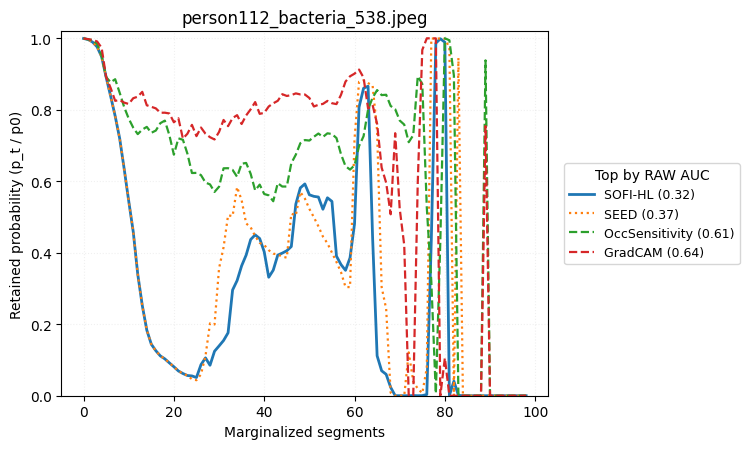

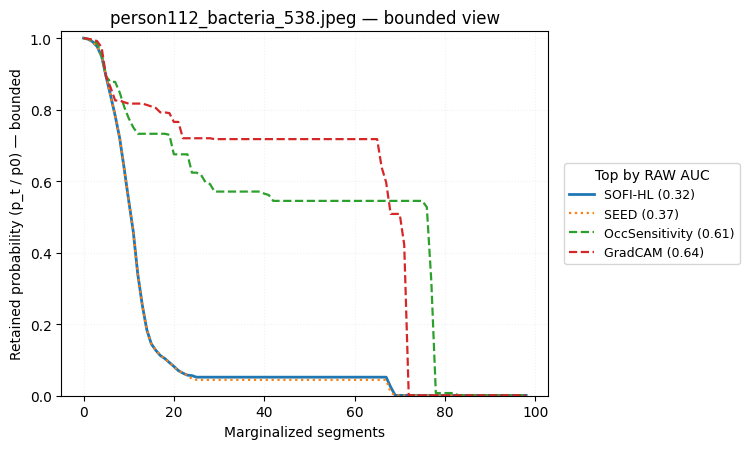

In [ ]:
plot_one_raw_clean(model, sal_model, imgs[0], DEVICE, n_segments=100, target_layer=TARGET_LAYER)
plot_one_bounded_clean(model, sal_model, imgs[0], DEVICE, n_segments=100, target_layer=TARGET_LAYER)


### Visualizations (bounded)

In [ ]:
plot_macro_raw_clean(model, sal_model, imgs, DEVICE, n_segments=100, target_layer=TARGET_LAYER)
plot_macro_bounded_clean(model, sal_model, imgs, DEVICE, n_segments=100, target_layer=TARGET_LAYER)


## Takeaways from the MoRF plots

- **Overall ranking (RAW AUC).**  
  Across both single-image and macro plots, **SOFI-HL** is consistently best (lowest RAW AUC), **SOFI-RL** and **SEED** trail closely, while **Grad-CAM/GradientSHAP/Score-CAM** are generally worse. This ordering holds on the averaged (macro) curves, not just on a single case.

- **Early-drop behavior matters.**  
  Methods that drive the curve down quickly (left side) remove truly critical regions first. The best methods show an early, steep decline; weaker ones decline late or wobble.

- **Segmentation granularity \(K\) changes the story.**  
  Performance and visual shape are **sensitive to the superpixel count**:  
  - Smaller \(K\) → coarse segments; occlusion steps are few but impactful.  
  - Larger \(K\) → finer control; more steps but also more variance per step.  
  Comparisons should use the **same \(K\)** (and SLIC params) to be fair.

- **Baseline choice influences MoRF.**  
  We replace occluded regions with the **training preprocessed mean** (scalar, in \([0,1]\)). Different baselines (zeros/blur/noise/class-conditional means) can move curves and AUCs. Keep the baseline **fixed across methods**.

- **RAW vs. bounded curves.**  
  - **RAW curves** (and **RAW AUC**) preserve all fluctuations and are our **primary metric** for ranking methods.  
  - Small ups/downs (BN/noise/thresholding effects) make RAW curves **noisy**—especially at high occlusion rates and large \(K\).  
  - **Bounded curves** apply a gentle monotone envelope; they are easier to read and yield **more stable AUCs**, so we also report **bounded AUC** as a robustness check, not as the main score.
